# 🚬 Smoking Status Prediction (КЕЙС №5) #
---
# 🧑‍🤝‍🧑 Команда проекта #
Участники:
- Фер Андрей - роль (MLE)
- Казанцев Дмитрий - роль (MLE)
- Стец Максим - роль (DA)
- Фабрикант Владислав - роль (DA)
- Михин Дмитрий - роль (DA)
- Александр Андреев - роль (SRE)
---
# 📖 Описание проекта #
Проект направлен на построение модели машинного обучения, которая по биосигналам и физиологическим показателям человека определяет, является ли он курильщиком или некурильщиком.
Модель обучается на медицинских данных (например, частота сердечных сокращений, уровень кислорода, холестерин, глюкоза и т. д.) и решает задачу бинарной классификации.

---
# 🎯 Цели проекта #
- Провести анализ биомедицинских данных (EDA)
- Подготовить и очистить данные для обучения
- Построить и сравнить несколько ML-моделей
- Выбрать наилучшую по метрикам качества
- Сохранить обученную модель для последующего использования (например, в Streamlit-приложении)
---
# 📦 Описание датасета #
Для проекта используется датасет соревнования:
Playground Series S3E24 — Smoking Status Prediction
Источник: Kaggle

Датасет содержит **159 256 наблюдений и 24 признака**, включая биометрические, физиологические и биохимические показатели здоровья человека.
Целевая переменная — smoking, принимает значения:
- 0 — человек не курит
- 1 — человек является курильщиком

## Группы признаков
## 🧍 Демографические
| Признак        | Описание         |
| -------------- | ---------------- |
| **age**        | возраст          |
| **height(cm)** | рост в см        |
| **weight(kg)** | вес в кг         |
| **waist(cm)**  | окружность талии |

## 👁👂 Физиологические
| Признак                  | Описание         |
| ------------------------ | ---------------- |
| **eyesight(left/right)** | острота зрения   |
| **hearing(left/right)**  | слух             |
| **systolic**             | верхнее давление |
| **relaxation**           | нижнее давление  |

## 🧬 Биохимические показатели крови
| Признак                 | Что означает                                          |
| ----------------------- | ----------------------------------------------------- |
| **Cholesterol**         | общий холестерин                                      |
| **HDL**                 | липопротеиды высокой плотности ("хороший холестерин") |
| **LDL**                 | липопротеиды низкой плотности ("плохой холестерин")   |
| **triglyceride**        | триглицериды                                          |
| **hemoglobin**          | гемоглобин                                            |
| **fasting blood sugar** | глюкоза натощак                                       |
| **serum creatinine**    | креатинин                                             |
| **Urine protein**       | белок в моче                                          |

## 🧪 Печёночные ферменты (важные для анализа курения!)
| Признак       | Расшифровка                                               |
| ------------- | --------------------------------------------------------- |
| **AST**       | Aspartate Aminotransferase — аспартатаминотрансфераза     |
| **ALT**       | Alanine Aminotransferase — аланинаминотрансфераза         |
| **Gtp (GGT)** | Gamma-Glutamyl Transferase — гамма-глутамилтранспептидаза |

## 🦷 Прочее
| Признак           | Значение      |
| ----------------- | ------------- |
| **dental caries** | кариес        |
| **id**            | идентификатор |
---
## 📄 Структура ноутбука

1. Загрузка и первичный анализ данных
2. Анализ данных (EDA)

## 1. Загрузка и первичный анализ данных

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, classification_report, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_validate, KFold, train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
plt.style.use('seaborn-v0_8')
pd.set_option("display.max_columns", None)

In [4]:
df = pd.read_csv("../data/raw/train.csv")

In [5]:
print("Shape:", df.shape)
display(df.head())

print("\nInfo:")
print(df.info())

display(df.describe().T)

Shape: (159256, 24)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL       

,count,mean,std,min,25%,50%,75%,max
id,159256.0,79627.500000,45973.391572,0.0,39813.75,79627.5,119441.25,159255.0
age,159256.0,44.306626,11.842286,20.0,40.00,40.0,55.00,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.00,165.0,170.00,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.00,65.0,75.00,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.00,83.0,89.00,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.80,1.0,1.20,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.80,1.0,1.20,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.00,1.0,1.00,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.00,1.0,1.00,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.00,121.0,130.00,213.0


## 🧩 Промежуточный итог: Общее представление о данных

**Размер датасета:** 159 256 строк × 24 признака
**Типы данных:** 19 `int64`, 5 `float64`
**Пропуски:** отсутствуют ✅

---

### ⚙️ Структура данных
- Демографические: `age`, `height(cm)`, `weight(kg)`, `waist(cm)`
- Физиологические: `systolic`, `relaxation`, `hearing`, `eyesight`
- Биохимические: `Cholesterol`, `LDL`, `HDL`, `triglyceride`, `AST`, `ALT`, `Gtp`
- Целевая переменная: **`smoking` (0 – не курит, 1 – курит)**

---

### 🚨 Потенциальные проблемы
- **Выбросы**: `LDL`, `triglyceride`, `ALT`, `AST`, `Gtp` имеют экстремальные значения (до 1000+)
- **Технические капы**: значения `9.9` в `eyesight` и `serum creatinine`
- **Классовый баланс:** 0 ≈ 56 %, 1 ≈ 44 % → допустимо, но требует стратификации
- **Многие признаки имеют разный масштаб (от бинарных до значений в тысячи), что важно учитывать перед обучением моделей — модели чувствительны к масштабированию.**
---

### 💡 Предварительные гипотезы
- Курильщики чаще имеют ↑ `Gtp`, `ALT`, `LDL`, `triglyceride` и ↓ `HDL`
- Возможна слабая зависимость от возраста и давления

---

## 2. Анализ данных (EDA)

,missing,missing_%


,count,pct
smoking,,
0,89603,56.26
1,69653,43.74


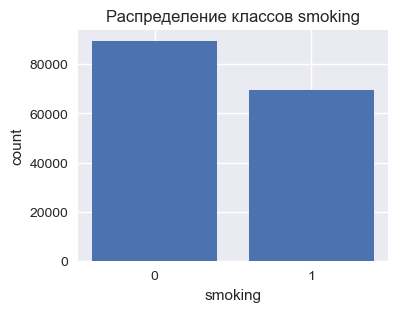

In [6]:
# Пропуски
na = df.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing": na, "missing_%": (na/len(df)*100).round(2)}).query("missing>0"))

# Дисбаланс классов
cls = df["smoking"].value_counts().sort_index()
display(pd.DataFrame({"count": cls, "pct": (cls/len(df)*100).round(2)}))
plt.figure(figsize=(4,3)); plt.bar(cls.index.astype(str), cls.values)
plt.title("Распределение классов smoking"); plt.xlabel("smoking"); plt.ylabel("count"); plt.show()

Мы считаем количество людей в каждом классе:

- 0 — не курит
- 1 — курит

Также строим график, чтобы визуально оценить баланс.

Это важно, потому что:

- сильный дисбаланс может привести к тому, что модели будут предсказывать только один класс;
- при необходимости можно применять стратификацию или методы балансировки (oversampling, undersampling).

👉 В нашем случае доли примерно 56% против 44% — это умеренный дисбаланс, который не критичен, но модель всё же лучше обучать со стратификацией.

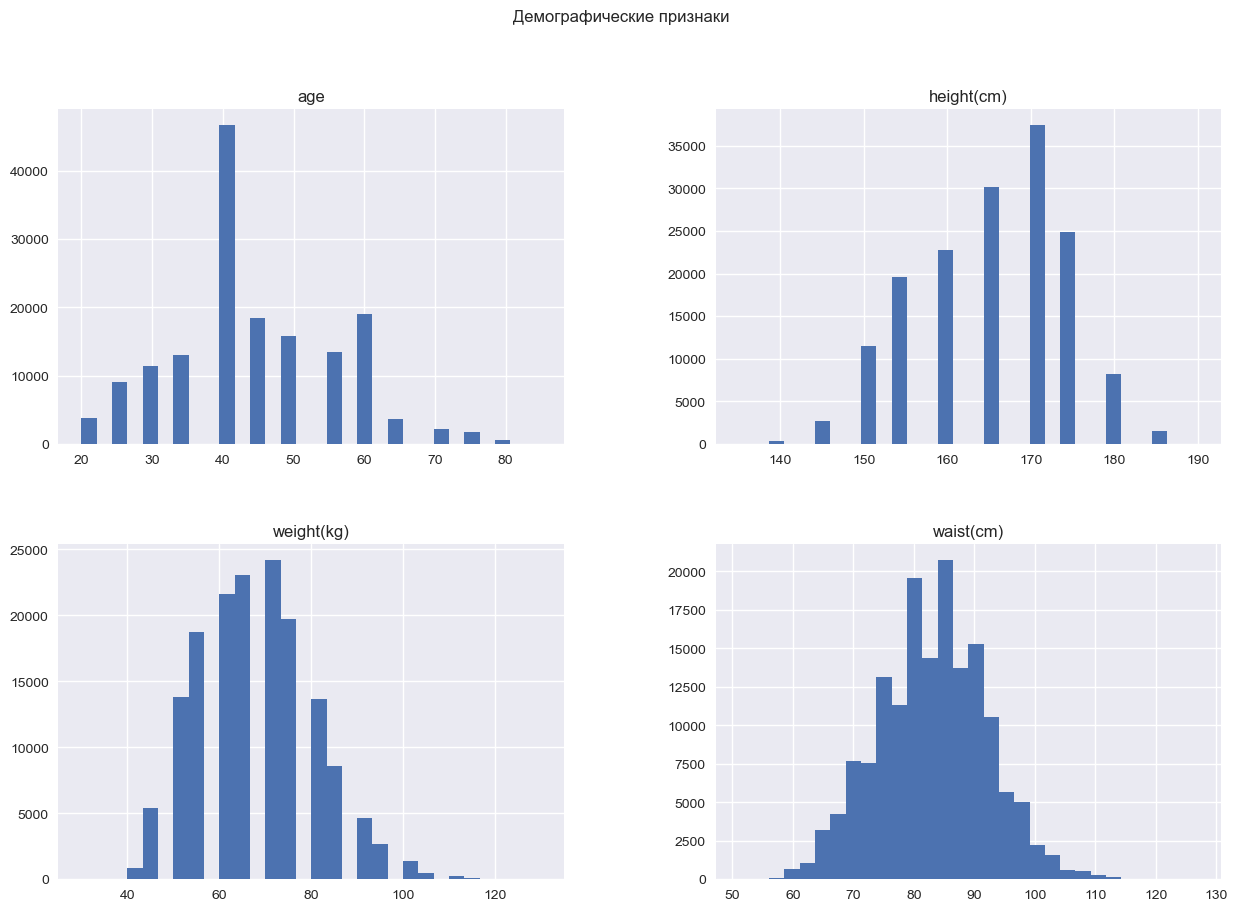

In [7]:
cols_demo = ["age", "height(cm)", "weight(kg)", "waist(cm)"]
df[cols_demo].hist(bins=30, figsize=(15,10))
plt.suptitle("Демографические признаки")
plt.show()

### ✅ Краткий вывод по демографическим признакам

1) Возраст (age)
- Распределение модально, с пиком примерно в районе 40–45 лет.
- Отчётливо видно, что большинство участников — люди среднего возраста.
- Мало наблюдений моложе 30 и старше 70 — распределение неравномерное.

📌 **Вывод:** датасет перекошен в сторону взрослых; это может влиять на закономерности курения, т.к. курение чаще среди людей 30–60 лет.

---
2) Рост (height)
- Распределение похоже на нормальное, пик около 165–170 см.
- Есть немного низких (<150) и высоких (>185), но без экстремальных выбросов.

📌 **Вывод:** рост распределён естественно, без аномалий. В целом — классическая колоколообразная форма.

---
3) Вес (weight)
- Тоже близко к нормальному распределению, но правый хвост более длинный.
- Пик примерно в районе 65–70 кг.
- Есть небольшое количество людей с весом >100 кг.

📌 **Вывод:** наблюдается лёгкий перекос вправо — из-за небольшой доли людей с избыточным весом.

---
4) Обхват талии (waist(cm))
- Явно сдвинут вправо.
- Основная масса значений 75–90 см.
- Хвост более тяжёлый (люди с талией 100–120 см).

📌 **Вывод:** наличие правого хвоста может указывать на людей с ожирением или метаболическими отклонениями — это потенциально важно, т.к. ожирение связано с курением и здоровьем в целом.

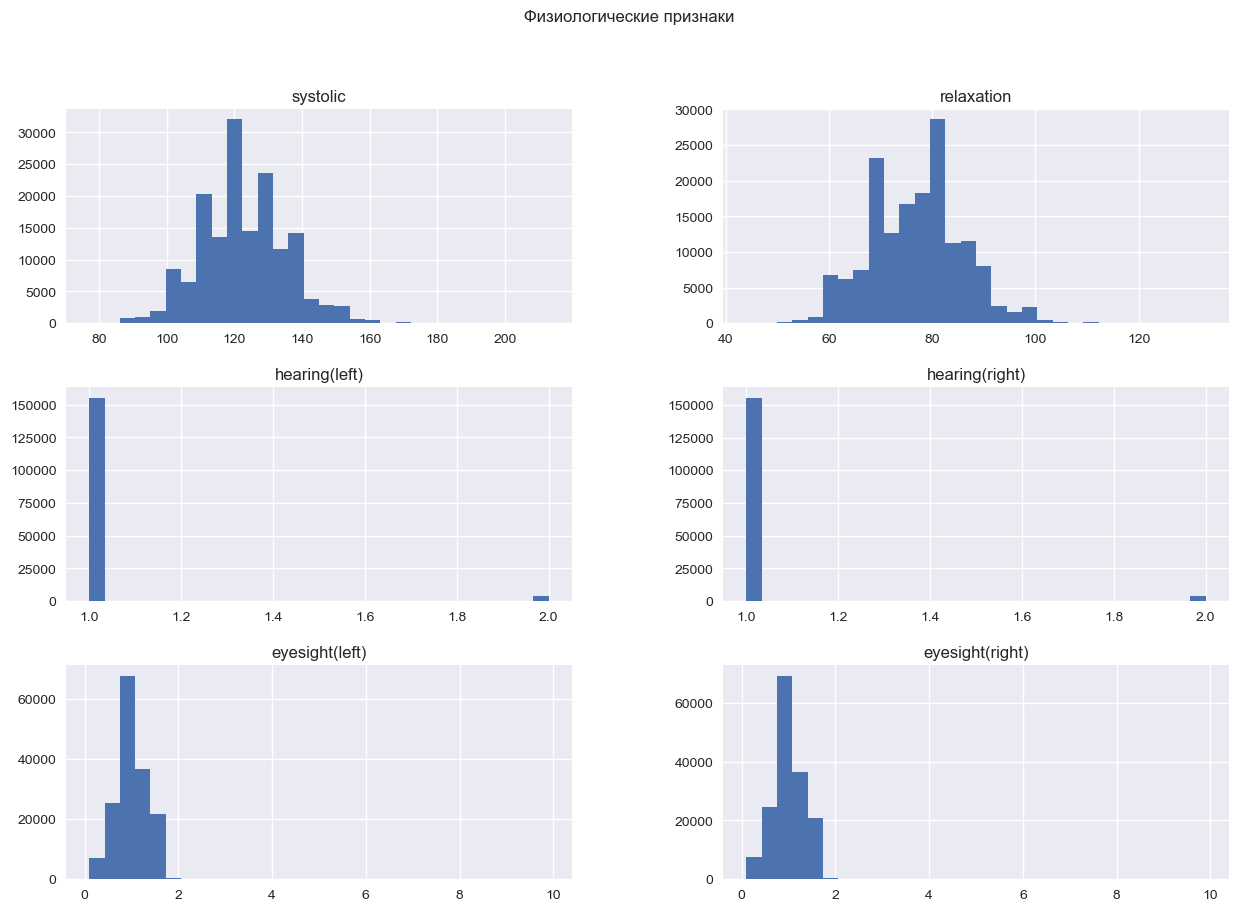

In [8]:
cols_phys = ["systolic", "relaxation", "hearing(left)", "hearing(right)",
             "eyesight(left)", "eyesight(right)"]
df[cols_phys].hist(bins=30, figsize=(15,10))
plt.suptitle("Физиологические признаки")
plt.show()

### 🧩 Краткий вывод по физиологическим признакам

1. Артериальное давление (systolic, relaxation)
- Оба признака распределены близко к нормальному, без резких выбросов
- Пик систолического давления — около 120 мм рт. ст., диастолического — 75–80 мм рт. ст.
- Видны «хвосты» вправо (повышенное давление у части людей), что типично для взрослой выборки.

👉 **Вывод:** давление может быть полезным признаком — оно косвенно связано со стрессом, образом жизни и вредными привычками.

---
2. Слух (hearing left/right)
- Почти все значения — 1, что означает "нормальный слух".
- Значений 2 крайне мало — фактически редкие отклонения.

👉 **Вывод:** признак почти константный, информативность для модели низкая.

---
3. Зрение (eyesight left/right)
- Основная масса — в диапазоне 0.8–1.2.
- Есть редкие большие значения (до 2.0), но их очень мало.
- Распределение слегка смещено влево (т.е. больше людей с небольшим снижением зрения).

👉 **Вывод:** признаки немного вариативные → могут давать слабый, но полезный сигнал. Курение снижает микроциркуляцию — связь возможна, но слабая.

---
### 🎯 Общий вывод по блоку физиологии
- Большинство физиологических признаков выглядят адекватно, без пропусков и аномалий.
- Слух почти не изменяется → вероятно, его можно исключить при моделировании.
- Давление и зрение в том виде, как есть, можно оставить — они умеренно вариативны.
- Значимых перекосов/ошибок нет — предобработка минимальна.

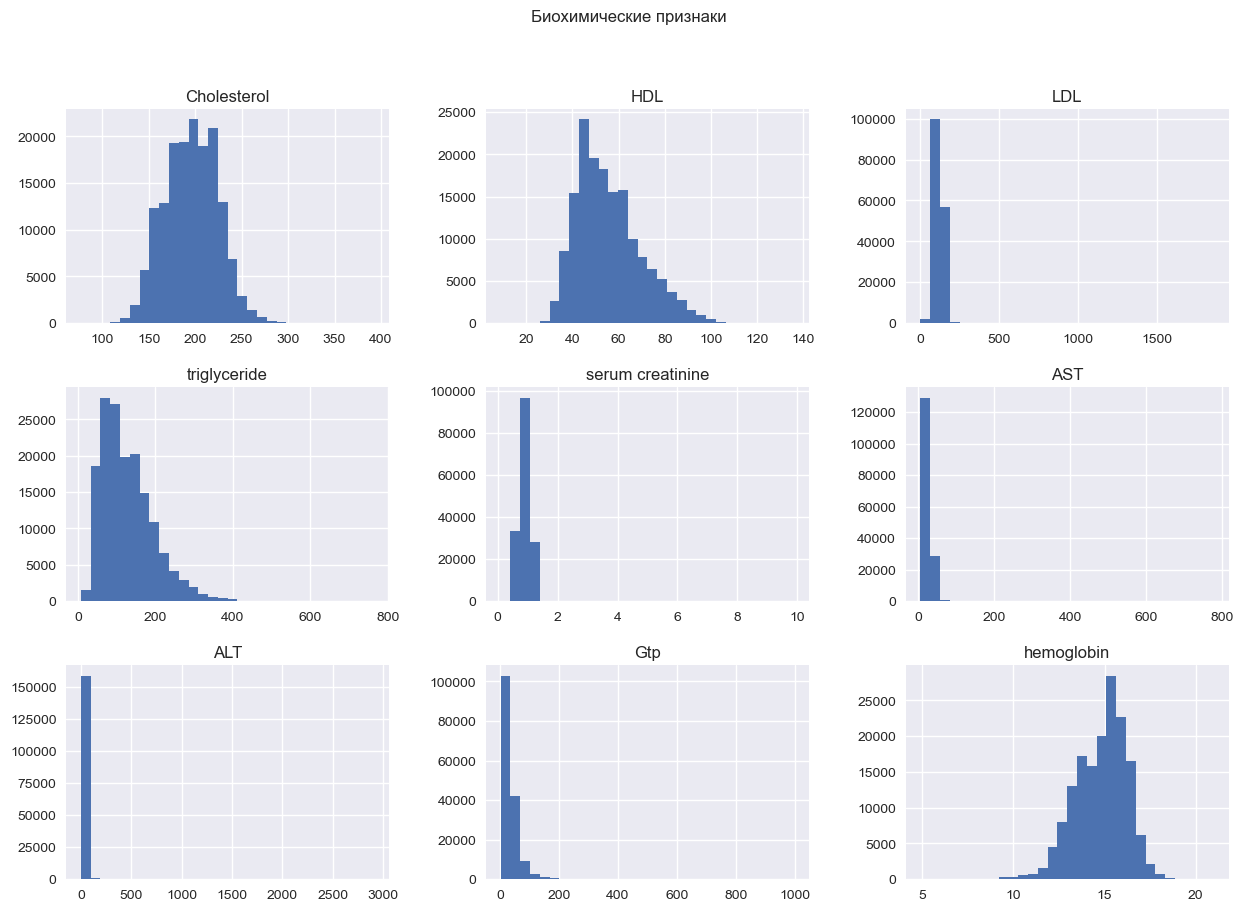

In [9]:
cols_bio = ["Cholesterol", "HDL", "LDL", "triglyceride",
            "serum creatinine", "AST", "ALT", "Gtp", "hemoglobin"]
df[cols_bio].hist(bins=30, figsize=(15,10))
plt.suptitle("Биохимические признаки")
plt.show()

### 🧪 Вывод по биохимическим признакам (Cholesterol, HDL, LDL, Triglyceride, AST, ALT, GTP, Hb, Creatinine)
1. Cholesterol (общий холестерин)
- Распределение близко к нормальному, основная масса значений — 150–250 мг/дл.
- Небольшой «тяжёлый хвост» вправо → возможны единичные пациенты с выраженной гиперхолестеринемией.

**Вывод:** признак информативный, выбросы умеренные.

---
2. HDL (липопротеины высокой плотности — “хороший” холестерин)
- Распределение смещено вправо, но выглядит адекватно для мед.данных.
- Значения в диапазоне 30–90 мг/дл, что совпадает с нормальными клиническими пределами.

**Вывод:** признак чистый, подойдет без трансформаций.

---
3. LDL (липопротеины низкой плотности — “плохой” холестерин)
- Очень сильный перекос вправо.
- Есть аномальные огромные значения до 1800+, которые невозможны в реальной медицине (обычно < 300).

**Вывод:** нужны:

✔ проверка выбросов,

✔ лог-трансформация или отсечение верхнего хвоста.

---
4. Triglyceride (триглицериды)
- Типичное логнормальное распределение (очень частый случай в медицине).
- Много высоких значений до 800+, что тоже похоже на реальные медицинские выбросы.

**Вывод:** лог-трансформация может улучшить распределение.

---
5. ALT (аланинаминотрансфераза)
- Оба признака имеют огромные пики около нижней границы и тяжёлый хвост вправо.
- Значения до 700–800, что слишком высоко — возможны ошибки ввода.
- Для нормальных людей ALT/AST ≈ 10–40.

**Вывод:** признаки критически перекошены →

✔ лог-преобразование,

✔ чистка выбросов по IQR/Z-score.

---
6. GTP (Gamma-GT — фермент печени)
- Аналогично AST/ALT — экстремальная асимметрия.
- Значения > 200 очень подозрительны.

**Вывод:** один из главных кандидатов на предобработку и очистку.

---
7. Hemoglobin (Hb — гемоглобин)
- Классическое нормальное распределение.
- Никаких выбросов.

**Вывод:** отличный, стабильный признак.

---
8. Serum Creatinine (креатинин)
- Перекос вправо.
- Много значений от 0.5 до 1.3 — нормально.
- Есть аномальные значения 5–10, что встречается редко и может испортить масштаб.

**Вывод:**

✔ ограничить верхние значения,

✔ рассмотреть лог-масштабирование.

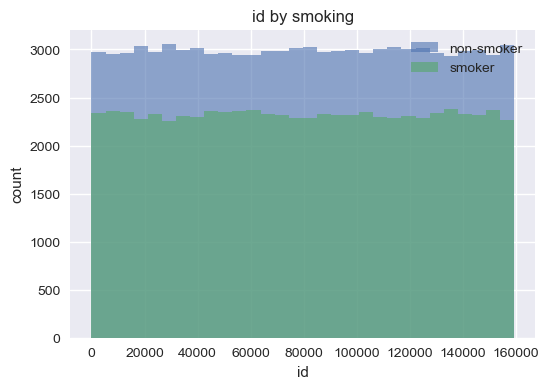

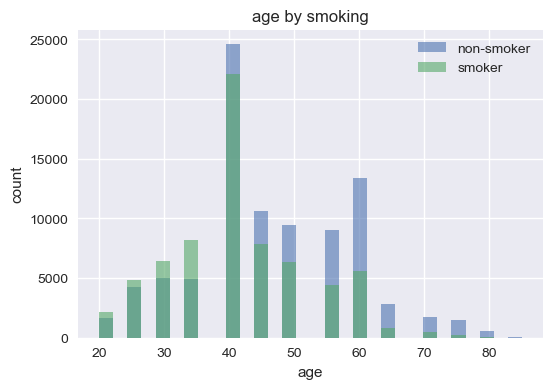

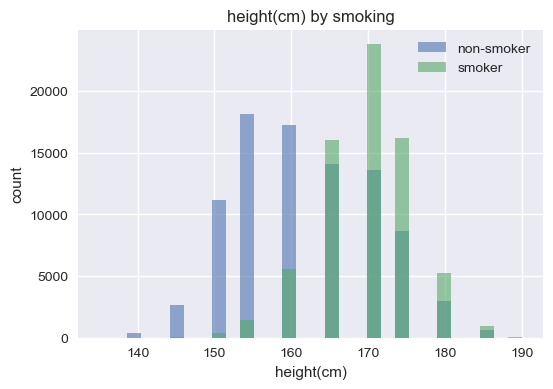

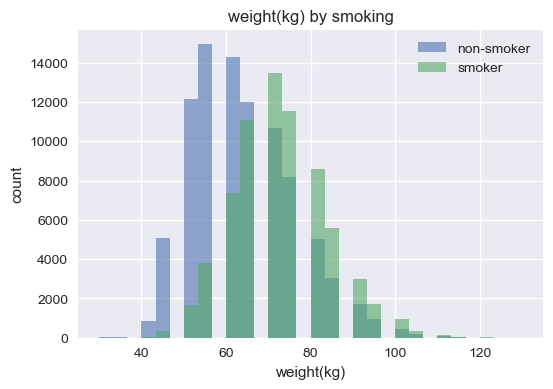

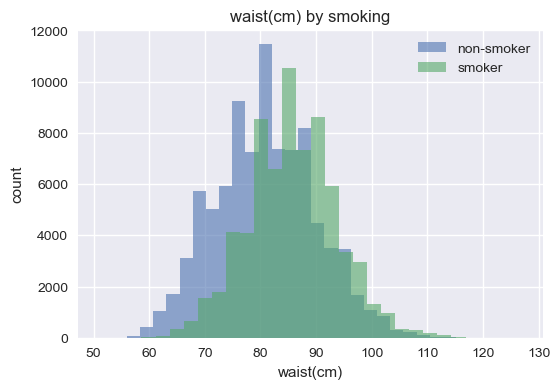

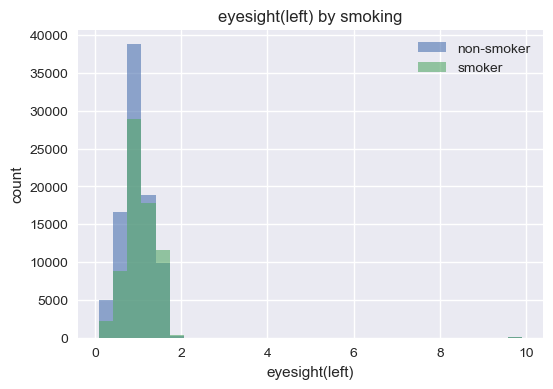

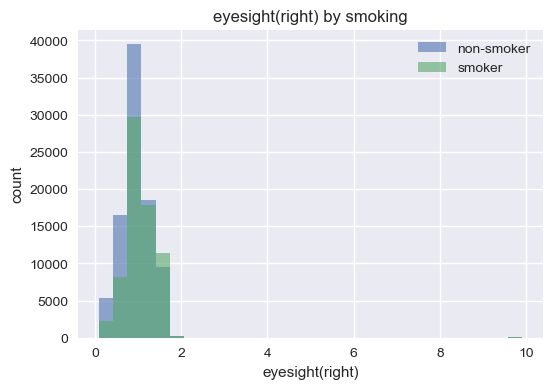

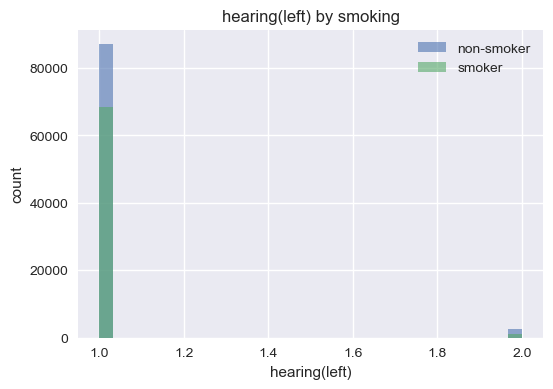

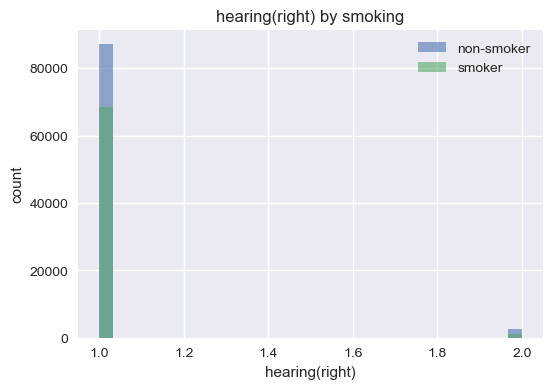

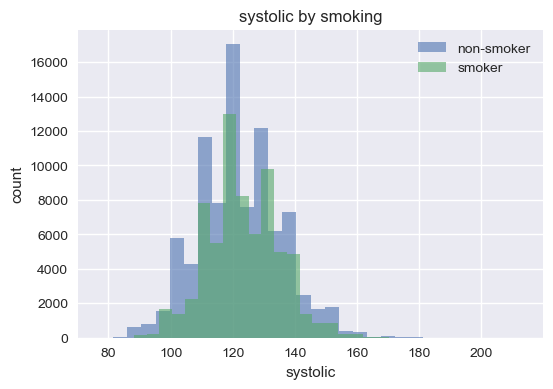

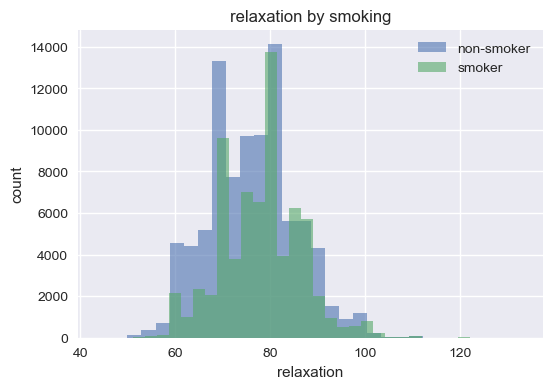

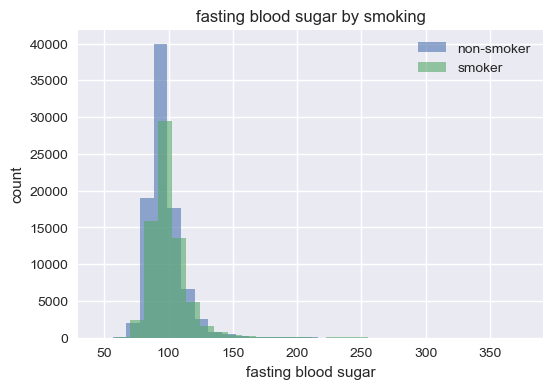

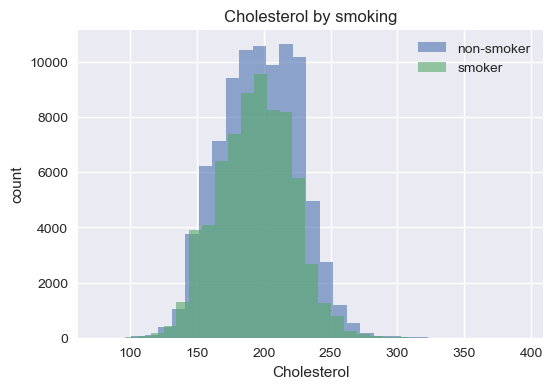

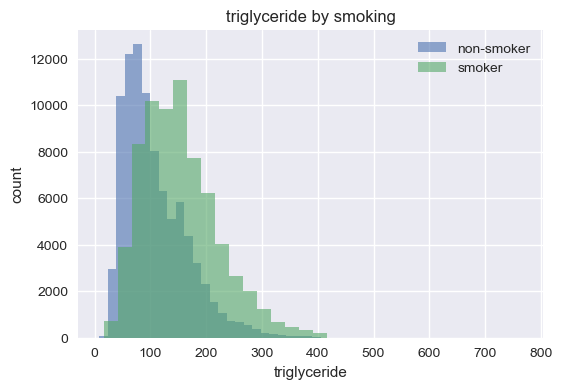

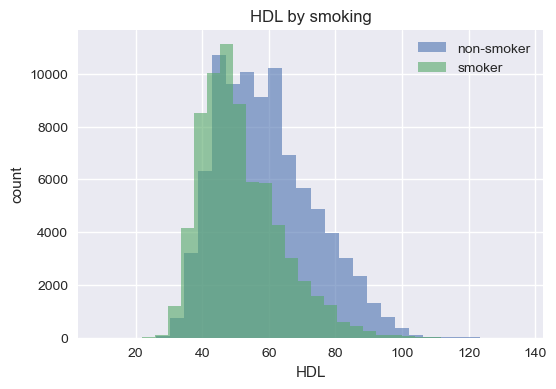

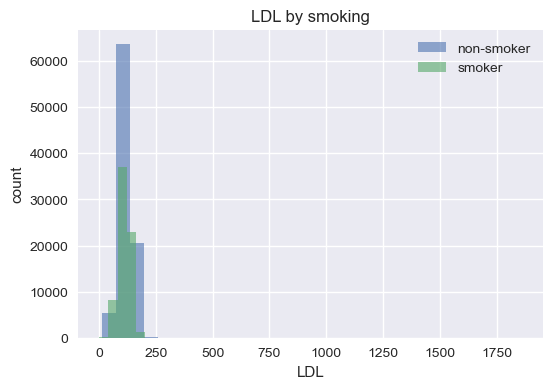

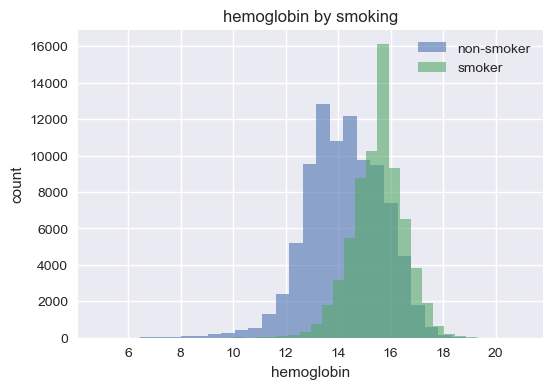

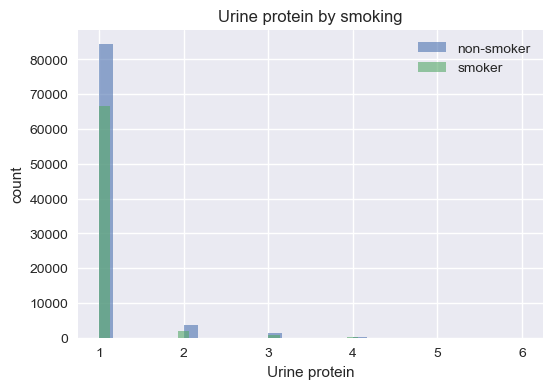

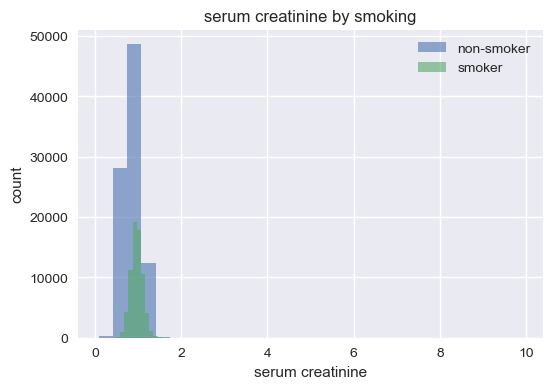

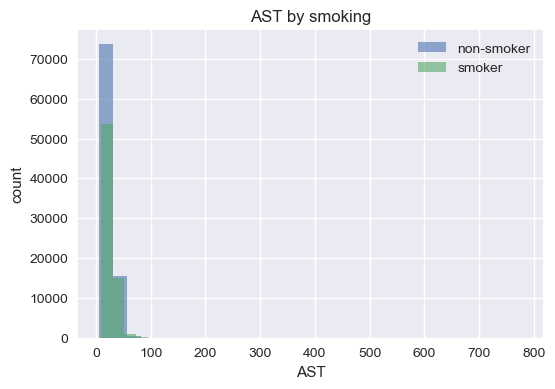

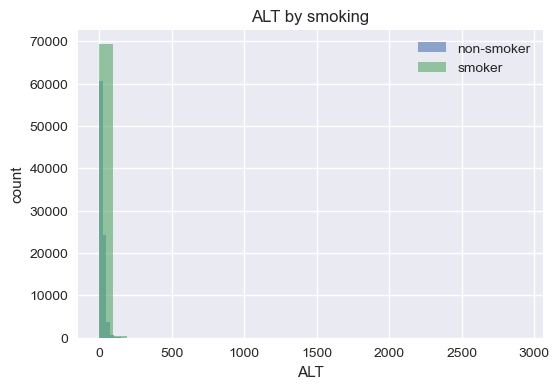

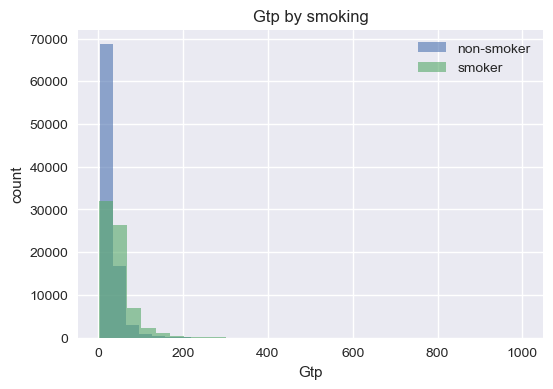

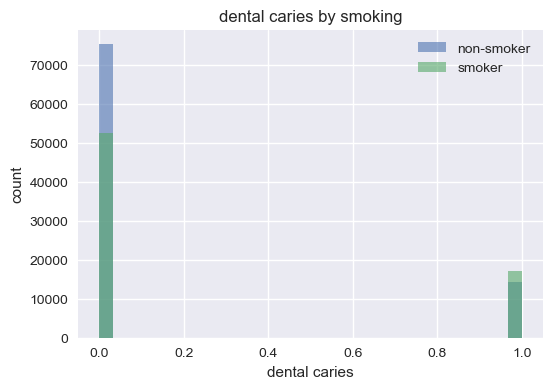

In [10]:
num_cols = df.select_dtypes(include=np.number).columns.drop("smoking")

for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[df["smoking"]==0][col], bins=30, alpha=0.6, label="non-smoker")
    plt.hist(df[df["smoking"]==1][col], bins=30, alpha=0.6, label="smoker")
    plt.title(f"{col} by smoking")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.legend()
    plt.show()

### Наблюдения по гистограммам
- **Возраст, рост:** формы близки, заметных сдвигов нет.
- **Вес и талия:** у курильщиков распределения немного смещены вправо → чуть выше масса и окружность талии.
- **Давление (systolic/relaxation):** у курильщиков пик правее → в среднем выше давление.
- **Глюкоза натощак:** различия минимальны.
- **Липиды:**
  - **triglyceride** — у курильщиков явный правый сдвиг (больше высоких значений).
  - **LDL** — правый хвост длиннее у курильщиков (разница умеренная).
  - **HDL** — у курильщиков левый сдвиг (ниже HDL).
  - **Cholesterol** — лёгкий правый сдвиг.
- **Печёночные ферменты:** **Gtp**, **ALT**, **AST** выраженно скошены вправо, у курильщиков больше высоких значений.
- **Hemoglobin:** у курильщиков чуть выше.
- **Urine protein, hearing, eyesight:** различия небольшие; hearing = 1 доминирует, eyesight и creatinine имеют технический «потолок» **9.9**.

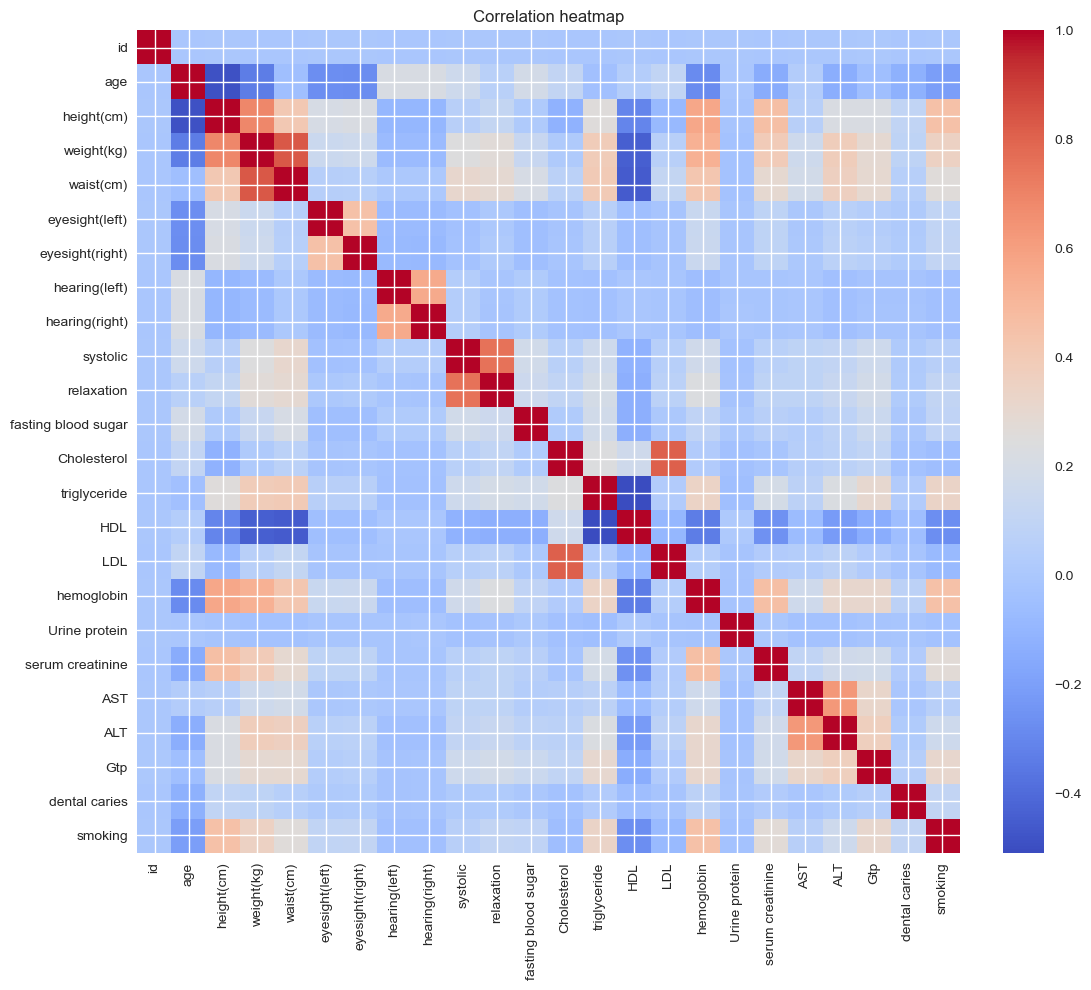

,corr_with_smoker
hemoglobin,0.450679
height(cm),0.447111
weight(kg),0.351748
triglyceride,0.331975
Gtp,0.305561
serum creatinine,0.272979
HDL,-0.271186
waist(cm),0.262715
age,-0.206033
ALT,0.163016


In [11]:
corr = df[num_cols.tolist()+["smoking"]].corr(numeric_only=True)

plt.figure(figsize=(12,10))
im = plt.imshow(corr, cmap="coolwarm", interpolation="none")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation heatmap"); plt.colorbar(im, fraction=0.046, pad=0.04); plt.tight_layout(); plt.show()

target_corr = corr["smoking"].drop("smoking").sort_values(key=lambda s: s.abs(), ascending=False)
display(target_corr.to_frame("corr_with_smoker").head(20))


### Топ-связи с `smoking` (по |corr|):
- **Положительные:** `hemoglobin (0.45)`, `height (0.45)`, `weight (0.35)`, `triglyceride (0.33)`, `Gtp (0.31)`, `serum creatinine (0.27)`, `waist (0.26)`, `ALT (0.16)`.
- **Отрицательные:** `HDL (-0.27)`, `age (-0.21)`, `LDL (-0.07)` (слабо).

### Интерпретация и важное замечание
- Сильные корреляции `hemoglobin` и `height` почти наверняка выступают **прокси пола** (в датасете нет колонки sex). Вероятно, в данных **мужчины чаще курят**, поэтому модели будут сильно опираться на эти признаки. Это повышает качество, но несёт риск **смещения/непереносимости**.
- Биохимические маркеры согласуются с ожиданиями: у курильщиков ↑ `Gtp`, `ALT`, `triglyceride` и ↓ `HDL`.

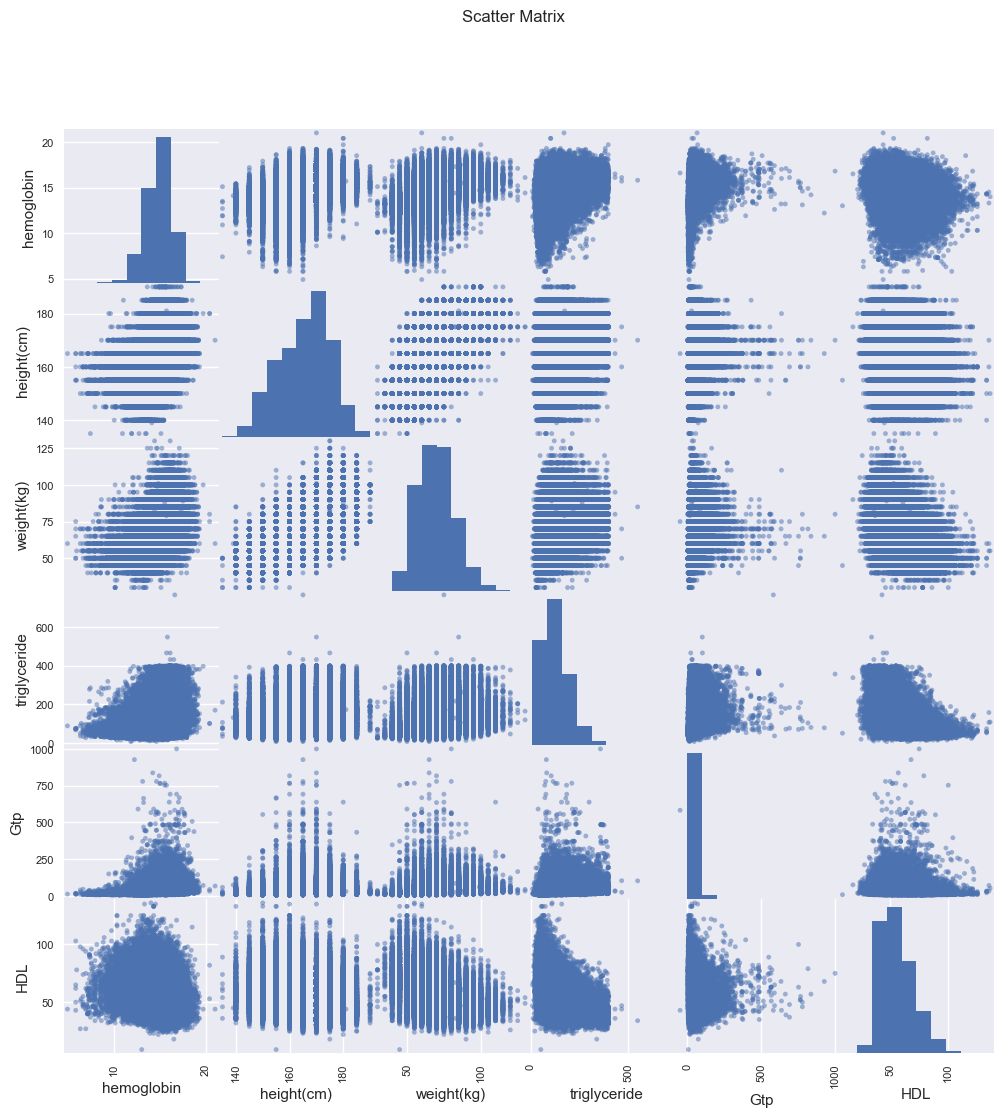

In [12]:
top = ['hemoglobin','height(cm)','weight(kg)','triglyceride','Gtp','HDL']
_ = scatter_matrix(df[top], figsize=(12,12), diagonal='hist')
plt.suptitle('Scatter Matrix'); plt.show()

### Наблюдения
- **Hemoglobin ↔ height/weight:** выраженная положительная зависимость (ожидаемо, отражает физические различия, вероятно, связанные с полом).
- **Triglyceride ↔ Gtp:** видна положительная зависимость, возможный общий фактор метаболического синдрома.
- **HDL** демонстрирует обратную зависимость к `triglyceride` и частично к `Gtp`.

### Выводы
- Scatter matrix подтверждает **корреляции из тепловой карты**.
- Есть выраженные **линейные кластеры**, особенно для антропометрических признаков.
- В данных заметны **плотные вертикальные полосы** — это результат **округления значений** в исходных измерениях (медицинские данные часто дискретизируются).
- Признаки выглядят разумно распределёнными, значимых выбросов не видно, кроме длинных хвостов у `triglyceride` и `Gtp`.

### Что дальше
→ Проверим количественно выбросы по IQR и Z-score, чтобы подтвердить хвостовые значения.
→ После этого сформируем **итог по выбросам и feature engineering** (BMI, WHtR, PulsePressure, лог-преобразования и т.д.).

In [13]:
out_iqr, out_z = defaultdict(dict), defaultdict(dict)
for c in num_cols:
    s = df[c].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75); iqr = q3-q1
    low, high = q1-1.5*iqr, q3+1.5*iqr
    out_iqr[c]["iqr_low"], out_iqr[c]["iqr_high"] = (s<low).sum(), (s>high).sum()
    m, sd = s.mean(), s.std(ddof=0)
    out_z[c]["z_abs>3"] = 0 if sd==0 else (((s-m).abs()/sd) > 3).sum()

out_tbl = (pd.DataFrame(out_iqr).T.rename(columns={"iqr_low":"iqr_low_outliers","iqr_high":"iqr_high_outliers"})
           .join(pd.DataFrame(out_z).T)).fillna(0).astype(int)
display(out_tbl.sort_values(["iqr_high_outliers","iqr_low_outliers","z_abs>3"], ascending=False).head(20))

,iqr_low_outliers,iqr_high_outliers,z_abs>3
dental caries,0,31532,0
Gtp,0,8792,2722
Urine protein,0,8394,2785
fasting blood sugar,346,7814,2159
ALT,0,6746,1689
AST,1,6336,1719
hearing(left),0,3818,3818
hearing(right),0,3730,3730
triglyceride,0,3087,1679
serum creatinine,2960,2983,281


## 🚨 Промежуточный итог: Выбросы (IQR & Z>3)

**Наиболее проблемные сверху (по IQR_high / Z>3):**
- `Gtp` **(8792 IQR_high, 2722 Z>3)** — длинный правый хвост.
- `ALT` **(6746 / 1689)**, `AST` **(6336 / 1719)** — сильная правоскошность.
- `triglyceride` **(3087 / 1679)** — выраженный хвост.
- `fasting blood sugar` **(7814 / 2159)** — заметные высокие значения.
- `serum creatinine` — **двусторонние** выбросы (2960 low, 2983 high) → подозрение на технический cap 9.9.
- `HDL`, `weight(kg)`, `waist(cm)`, `BP` — умеренные хвосты.

**Почему тут так много:**
- `dental caries` (0/1), `hearing(left/right)` (1/2), `Urine protein` (1..6) — **дискретные/категориально-ординальные** признаки. IQR у них «наказывает» крайние уровни, но это **не ошибка** данных.

**Выводы**
- Сильно правоскошные: **Gtp, ALT, AST, triglyceride, fasting blood sugar** → лог-преобразование.
- Двусторонние выбросы: **serum creatinine** → клиппинг по квантилям; проверить долю тех.значения **9.9**.
- Дискретные (`dental caries`, `hearing*`, `Urine protein`) **не клиппуем**, обрабатываем как категориальные/ординальные.


In [14]:
for c in ['serum creatinine','eyesight(left)','eyesight(right)']:
    cap99 = (df[c] >= 9.9).mean()*100
    print(f"{c}: доля значений >= 9.9 = {cap99:.3f}%")

serum creatinine: доля значений >= 9.9 = 0.001%
eyesight(left): доля значений >= 9.9 = 0.083%
eyesight(right): доля значений >= 9.9 = 0.073%


## ✅ Проверка технических «каповых» значений (9.9)

- `serum creatinine ≥ 9.9`: **0.001%**
- `eyesight(left) ≥ 9.9`: **0.083%**
- `eyesight(right) ≥ 9.9`: **0.073%**

**Вывод:** доли ничтожны → не влияют на распределения.
**Действие:** можно оставить как есть **или** аккуратно клипповать по верхнему квантилю (например, 99.5%), чтобы не мешали масштабированию.

In [15]:
fe = df.copy()
fe["BMI"] = fe["weight(kg)"]/(fe["height(cm)"]/100)**2
fe["WHtR"] = fe["waist(cm)"]/fe["height(cm)"]
fe["PulsePressure"] = fe["systolic"] - fe["relaxation"]
fe["non_HDL"] = fe["Cholesterol"] - fe["HDL"]
fe["LDL_to_HDL"] = fe["LDL"]/fe["HDL"].replace(0, np.nan)
fe["TG_to_HDL"]  = fe["triglyceride"]/fe["HDL"].replace(0, np.nan)
fe["AST_to_ALT"] = fe["AST"]/fe["ALT"].replace(0, np.nan)
for c in ["triglyceride","Gtp","ALT","AST"]:
    fe[f"log_{c}"] = np.log1p(fe[c])

fe[["BMI","WHtR","PulsePressure","LDL_to_HDL","TG_to_HDL","AST_to_ALT"]].describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,159256.0,24.452825,3.368651,11.718750,22.222222,24.221453,26.159334,45.785640
WHtR,159256.0,0.502491,0.050137,0.300000,0.468571,0.500000,0.535172,0.793750
PulsePressure,159256.0,45.629578,8.396904,-7.000000,40.000000,45.000000,50.000000,131.000000
LDL_to_HDL,159256.0,2.183459,0.750977,0.021739,1.653061,2.142857,2.660714,39.574468
TG_to_HDL,159256.0,2.579325,1.745235,0.123077,1.240506,2.150943,3.489796,18.777778
AST_to_ALT,159256.0,1.111938,0.435729,0.010638,0.818182,1.062500,1.333333,43.000000


## Итог по Feature Engineering

**Сводка (describe):**
- **BMI**: средн. 24.45 (Q1–Q3 ≈ 22.22–26.16) — реалистично.
- **WHtR**: средн. 0.502 (Q1–Q3 ≈ 0.469–0.535) — типичные значения.
- **PulsePressure**: средн. 45.6; min = **–7** → единичные аномалии измерений (редкие).
- **LDL_to_HDL**: средн. 2.18, **max 39.57** (деление на очень малый HDL) → выбросы-отношения.
- **TG_to_HDL**: средн. 2.58, **max 18.78** → аналогично, хвост.
- **AST_to_ALT**: средн. 1.11, **max 43** → при очень малом ALT.

**Выводы и действия**
- Отношения имеют длинные хвосты из-за маленького знаменателя → перед моделями:
  1) заменить нули в знаменателях на малое число/NaN (ты сделал `replace(0, np.nan)` — ок),
  2) **клиппинг верхних квантилей** (напр., 99.5%) для `LDL_to_HDL`, `TG_to_HDL`, `AST_to_ALT`,
  3) скорректировать редкие отрицательные `PulsePressure` (клиппинг ≥0).

# Baseline-модель

### Разделение датасета на обучающую и тестовую выборки без стратификации

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    fe.drop('smoking', axis=1),
    fe['smoking'],
    random_state=42
)

### ⚖️ Сравнение баланса классов в сформированных выборках

Text(0.5, 1.0, 'Тестовая выборка')

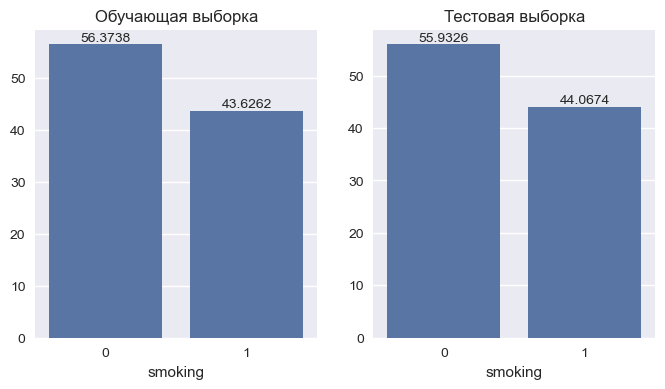

In [17]:
# Вычисляем отношения классов в сформированных выборках
train_class_ratios = y_train.value_counts(normalize=True) * 100
test_class_ratios = y_test.value_counts(normalize=True) * 100

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x=train_class_ratios.index, y=train_class_ratios.values, ax=axs[0])
axs[0].bar_label(axs[0].containers[0], fontsize=10)
axs[0].set_title('Обучающая выборка')

sns.barplot(x=test_class_ratios.index, y=test_class_ratios.values, ax=axs[1])
axs[1].bar_label(axs[1].containers[0], fontsize=10)
axs[1].set_title('Тестовая выборка')

Можем заметить, что между классами в обучающей и тестовой выборке есть незначительный дисбаланс (< 0.5).

Воспользуемся методом стратификации при формировании выборок для минимизации дисбаланса

### 🎓 Формирование пайплайна и обучение модели (без балансировки классов)

In [18]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression(random_state=42, max_iter=1000)
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

### 📚 Кросс-валидация методом K-Fold без стратификации

In [19]:
# Создаем KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=['f1', 'roc_auc'],
    return_train_score=True,
    n_jobs=-1
)

df = pd.DataFrame(cv_metrics, index=['1', '2', '3', '4', '5'])
mean_metrics = pd.DataFrame(df.mean(), columns=['Mean']).T
df = pd.concat([df, mean_metrics])

df

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc
1,1.363519,0.051651,0.736602,0.735634,0.845100,0.843510
2,1.570536,0.045134,0.734390,0.735510,0.843383,0.843842
3,1.665168,0.039021,0.731694,0.735325,0.843229,0.844080
4,1.511505,0.045134,0.735602,0.734824,0.841804,0.844416
5,1.540175,0.040994,0.737061,0.735541,0.844558,0.843676
Mean,1.530181,0.044387,0.735070,0.735367,0.843615,0.843905


### 📈 ROC-кривая и матрица ошибок для модели на валидационной выборке (без балансировки классов)

Text(0.5, 1.0, 'Confusion Matrix')

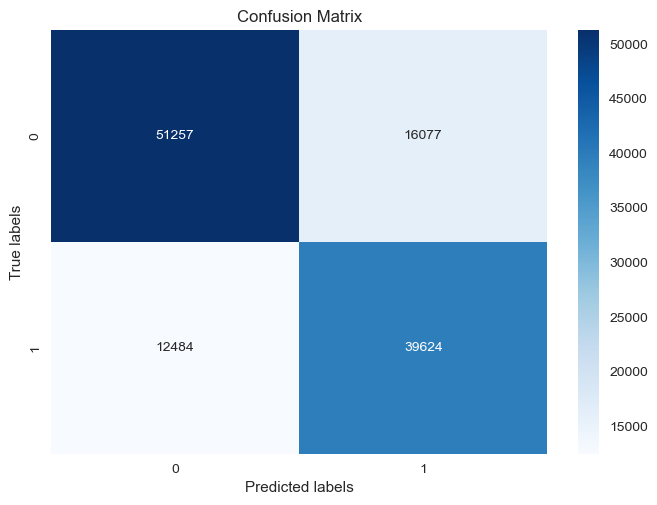

In [20]:
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=kf, n_jobs=-1)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### 📈 ROC-кривая и матрица ошибок для модели на тестовой выборке (без балансировки классов)

Text(0.5, 1.0, 'Confusion Matrix')

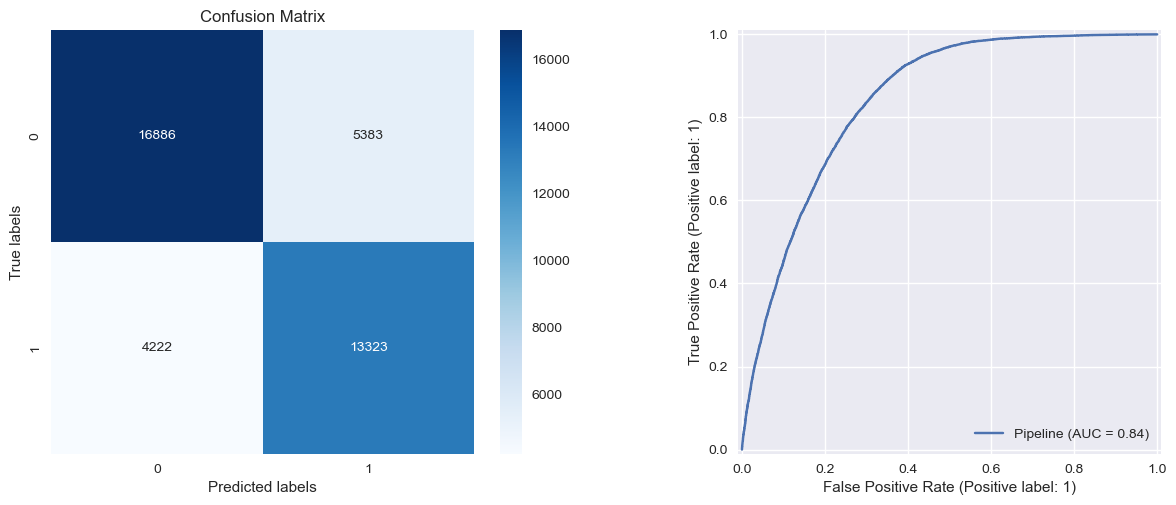

In [21]:
y_pred = pipeline.predict(X_test)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])

RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=axs[1])

axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_title('Confusion Matrix')

In [22]:
y_true = y_test
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(f"Accuracy без балансировки классов: {accuracy_score(y_test, y_pred)}")

scores = precision_recall_fscore_support(y_true, y_pred)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

scores

Accuracy без балансировки классов: 0.7587532023911187
ROC-AUC: 0.8417371848332216


,0,1,Mean
Precision,0.799981,0.712231,0.756106
Recall,0.758274,0.759362,0.758818
F-Score,0.778569,0.735042,0.756806
Support,22269.000000,17545.000000,19907.000000


### 🎓 Формирование пайплайна и обучение модели (с балансировкой классов)

In [23]:
pipeline = make_pipeline(
  StandardScaler(),
  LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_true = y_test

### 📚 Кросс-валидация методом Stratified K-Fold

In [24]:
# Создаем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring=['f1', 'roc_auc'],
    return_train_score=True,
    n_jobs=-1
)

df = pd.DataFrame(cv_metrics, index=['1', '2', '3', '4', '5'])
mean_metrics = pd.DataFrame(df.mean(), columns=['Mean']).T
df = pd.concat([df, mean_metrics])

df

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc
1,1.466260,0.050999,0.752777,0.753348,0.841080,0.844329
2,1.469362,0.051045,0.753561,0.752635,0.845997,0.842971
3,1.463411,0.042038,0.751872,0.753185,0.841568,0.844118
4,1.605355,0.028076,0.747694,0.753835,0.840400,0.844343
5,1.351299,0.046008,0.758738,0.751546,0.847812,0.842505
Mean,1.471138,0.043634,0.752928,0.752910,0.843371,0.843653


### 📈 ROC-кривая и матрица ошибок для модели на валидационной выборке (с балансировкой классов)

Text(0.5, 1.0, 'Confusion Matrix')

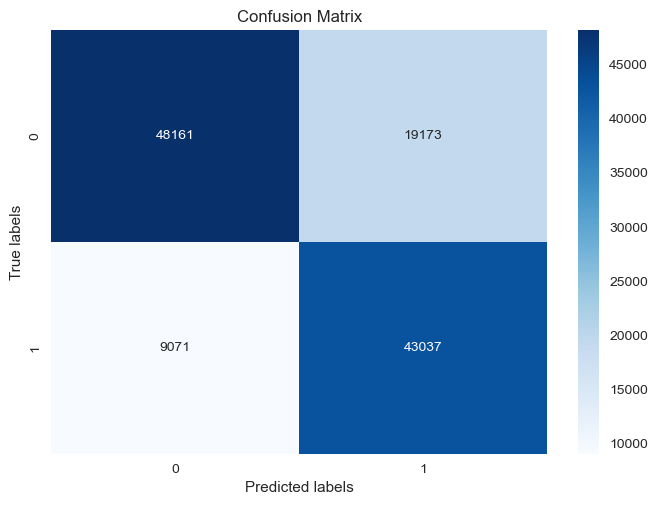

In [25]:
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### 📈 ROC-кривая и матрица ошибок для модели на тестовой выборке (с балансировкой классов)

Text(0.5, 1.0, 'Confusion Matrix')

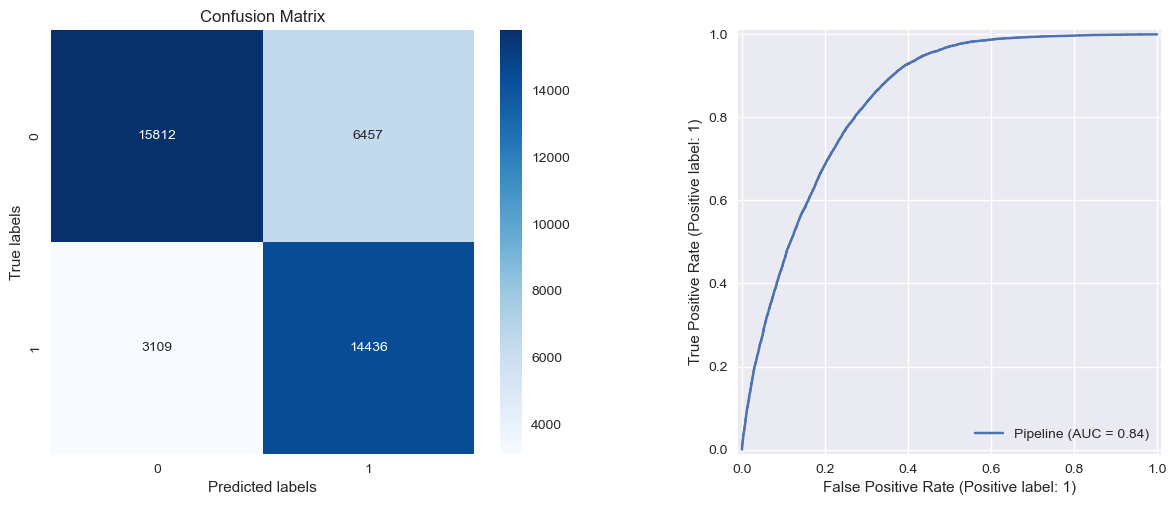

In [26]:
y_pred = pipeline.predict(X_test)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=axs[1])

axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_title('Confusion Matrix')

In [27]:
y_true = y_test
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]

print(f"Accuracy с балансировкой классов: {accuracy_score(y_true, y_pred)}")

scores = precision_recall_fscore_support(y_true, y_pred)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

scores

Accuracy с балансировкой классов: 0.7597327573215452
ROC-AUC: 0.8415052581059532


,0,1,Mean
Precision,0.835685,0.690949,0.763317
Recall,0.710045,0.822799,0.766422
F-Score,0.767759,0.751132,0.759445
Support,22269.000000,17545.000000,19907.000000


### Пороги вероятности и зависимость целевых метрик от значения порога

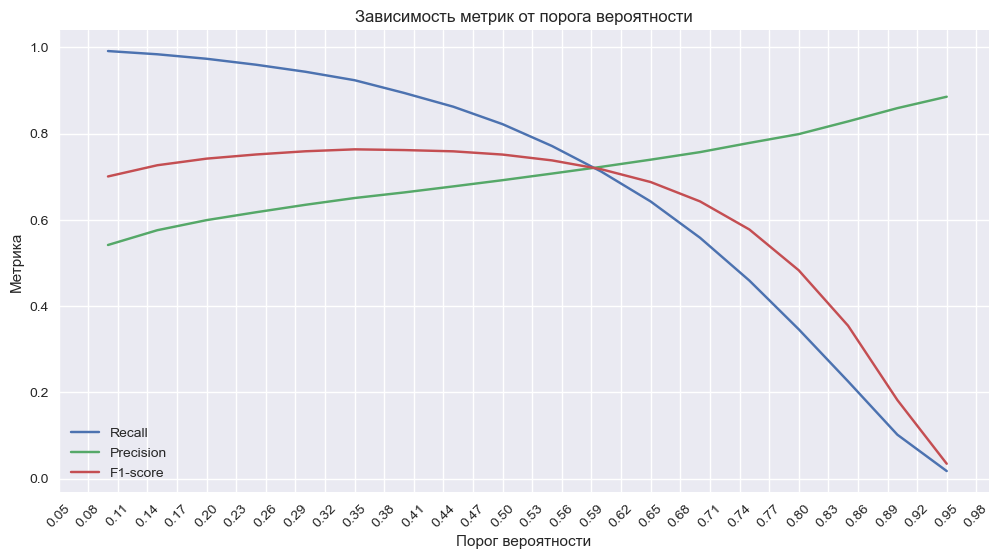

In [28]:
# Нас интересует только вероятность класса (второй столбец)
y_proba_pred = cross_val_predict(pipeline, X_test, y_test, cv=skf, method='predict_proba')[:, 1]

# Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #Пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
    #В противном случае — к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(recall_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Строим линейный график зависимости recall от threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости precision от threshold
plt.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости F1 от threshold
plt.plot(thresholds, f1_scores, label='F1-score')

plt.title('Зависимость метрик от порога вероятности')
plt.xlabel('Порог вероятности')
plt.ylabel('Метрика')
plt.xticks(thresholds)
plt.xticks(np.arange(0.05, 1, 0.03), rotation=45)
plt.grid(True)
plt.legend()

,0,1,Mean
Precision,0.880733,0.666197,0.773465
Recall,0.649288,0.888401,0.768845
F-Score,0.747506,0.761419,0.754462
Support,22269.000000,17545.000000,19907.000000


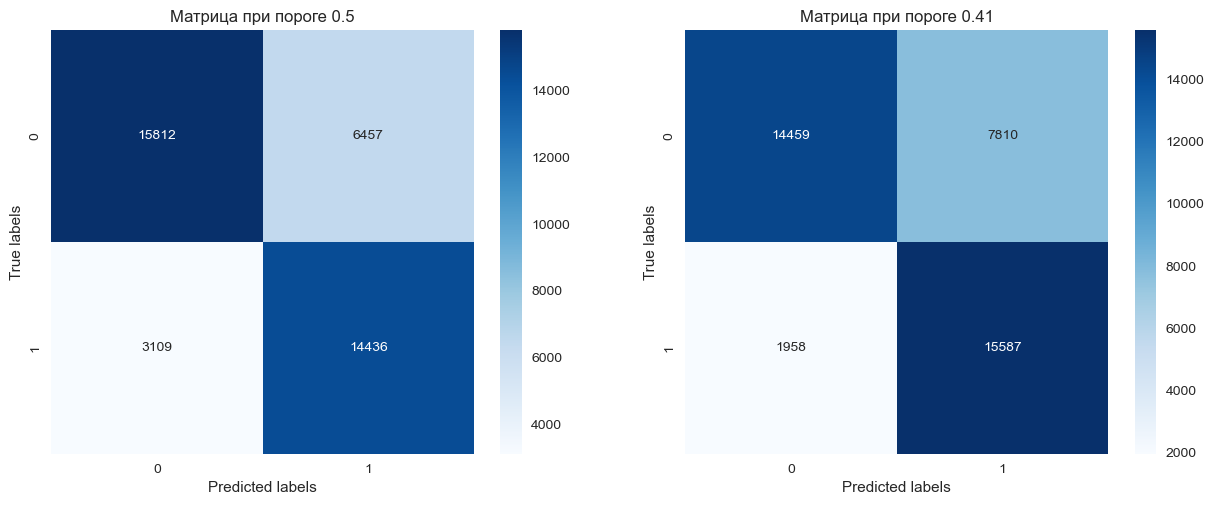

In [29]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.41
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

fig, axs = plt.subplots(1, 2)

fig.set_figwidth(15)
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Blues', ax=axs[1])

y_pred = pipeline.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])

axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_title('Матрица при пороге 0.5')

axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')
axs[1].set_title('Матрица при пороге 0.41')

scores = precision_recall_fscore_support(y_test, y_pred_opt)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

scores

## Вывод по модели с результатами на валидации и тесте

### 1. Количественная оценка производительности

Модель показывает высокое и стабильное качество на обеих выборках:

- **ROC-AUC**: 0.844 (валидация) → 0.840 (тест) - **снижение на 0.004**
- **F1-Score**: 0.753 (валидация) → 0.754 (тест) - **улучшение на 0.001**

### 2. Анализ стабильности и обобщающей способности

Минимальное изменение метрик ROC-AUC и F1-Score указывает на отсутствие переобучения

### 3. Детальный анализ метрик

**По ROC-AUC:**

- **ROC-AUC = 0.840** на тесте подтверждает, что модель обладает высокой разделяющей способностью

**По F1-Score:**

- **F1-Score = 0.754** на тесте показывает, что модель имеет балансированное качество классификации с хорошим балансом между точностью и полнотой

### 4. Краткий вывод

Высокие и стабильные показатели ROC-AUC, F1-Score демонстрируют, что Baseline-модель достаточно хорошо разделяет классы (**ROC-AUC > 0.8**) и имеет баланс между точностью и полнотой (**F1-Score > 0.75**), из чего можно сделать вывод – Baseline уверенно моделирует целевой признак.

# 🌳 Decision Tree baseline #

### 🎓 Формирование пайплайна и обучение модели  
Этап масштабирования (StandardScaler) пропускаем  
как неактуальный для решающих деревьев  

Деревья сохранены в ../data/decision_trees/ в формате .png'

Зависимость accuracy от ограничения на глубину depth:

    accuracy 0.7228  @  depth_2
    accuracy 0.6936  @  depth_2_balanced
    accuracy 0.7258  @  depth_3
    accuracy 0.7245  @  depth_3_balanced
    accuracy 0.7424  @  depth_4
    accuracy 0.7426  @  depth_4_balanced
    accuracy 0.7466  @  depth_5
    accuracy 0.7431  @  depth_5_balanced
    accuracy 0.7525  @  depth_6
    accuracy 0.7529  @  depth_6_balanced
    accuracy 0.7523  @  depth_7
    accuracy 0.7512  @  depth_7_balanced
    accuracy 0.7521  @  depth_8
    accuracy 0.7513  @  depth_8_balanced


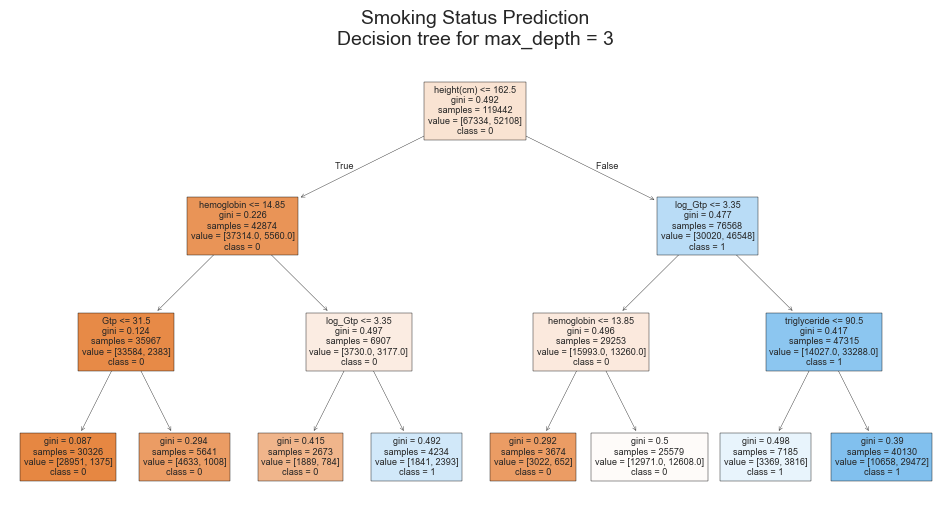

In [30]:
# Cемейство деревьев в цикле по гиперпараметрам:
tree_accuracies = dict()
for DEPTH in range(2, 9): 
    for CLASS_WEIGHT in [None, 'balanced']:
        pipeline_tree = DecisionTreeClassifier(max_depth=DEPTH, random_state=42, class_weight=CLASS_WEIGHT)
        # Обучение модели:
        pipeline_tree.fit(X_train, y_train)
        predictions = pipeline_tree.predict(X_test)
        
        # Оценка модели - расчет точности:
        variant = 'depth_' + str(DEPTH) 
        if CLASS_WEIGHT != None:
            variant += '_' + str(CLASS_WEIGHT)
        tree_accuracies[variant] = accuracy_score(y_test, predictions)
        
        # Визуализация дерева:
        fig = plt.figure(figsize=(12, 6))
        plot_tree(pipeline_tree, feature_names=X_train.columns.tolist(), class_names=['0','1'], filled=True)
        plt.title(f"Smoking Status Prediction\nDecision tree for max_depth = {DEPTH}", fontsize=14)
        plt.savefig("../data/decision_trees/" + variant + '.png', dpi=1200, bbox_inches='tight')
        # отобразим в ноутбуке только одно из деревьев:
        if DEPTH != 3 or CLASS_WEIGHT != None:  plt.close(fig)  
print("Деревья сохранены в ../data/decision_trees/ в формате .png'\n")
print("Зависимость accuracy от ограничения на глубину depth:\n")
for p, a in tree_accuracies.items():
    print(f'    accuracy {a:.4f}  @  {p}') 
# display(pd.Series(tree_accuracy))

Модель достаточно быстро обучается, поэтому из ограничений по гиперпараметрам  
оставлены только глубина и балансировка классов.  
Заметим, что максимум accuracy достигается при глубине 6 и балансировке классов  
и равен 0.753. Изучим фичи, которые метод DecisionTreeClassifier использовал или,  
наоборот, не использовал для построения такого оптимального дерева: 

In [31]:
DEPTH = 6

pipeline_tree = DecisionTreeClassifier(max_depth=DEPTH, random_state=42, class_weight='balanced')
pipeline_tree.fit(X_train, y_train)
predictions = pipeline_tree.predict(X_test)

print("\nФичи, попавшие в дерево (по критерию feature_importances_ > 0):\n")

# Расчет feature_importances_ основывается на взвешенном снижении 
# критерия неопределенности (например, gini или энтропии) на каждом узле, 
# где используется данный признак.
# По feature_importances_ создаем список пар (название фичи, важность):
importances = pipeline_tree.feature_importances_
feature_names = X_train.columns.tolist()
feature_importance_pairs = list(zip(feature_names, importances))

# Фильтруем фичи с важностью > 0
used_features_importance_based = [name for name, importance in feature_importance_pairs if importance > 0]

print(f"Количество использованных фичей: {len(used_features_importance_based)} из {len(feature_names)-1}")
print("\nИспользованные фичи по важности:")
sorted_features = sorted(feature_importance_pairs, key=lambda item: item[1], reverse=True)
for name, importance in sorted_features:
    if importance > 0:
        print(f"  {name:20s}: {importance:.4f}")
print("\nНеиспользованные фичи:")
for name in feature_names:
    if name not in used_features_importance_based and name != 'id': 
        print(f"  {name}")




Фичи, попавшие в дерево (по критерию feature_importances_ > 0):

Количество использованных фичей: 20 из 33

Использованные фичи по важности:
  height(cm)          : 0.6372
  hemoglobin          : 0.1397
  log_Gtp             : 0.1106
  log_triglyceride    : 0.0234
  Gtp                 : 0.0224
  triglyceride        : 0.0207
  LDL                 : 0.0176
  age                 : 0.0068
  TG_to_HDL           : 0.0067
  serum creatinine    : 0.0050
  log_AST             : 0.0037
  AST                 : 0.0012
  HDL                 : 0.0009
  ALT                 : 0.0008
  Cholesterol         : 0.0007
  dental caries       : 0.0007
  LDL_to_HDL          : 0.0007
  BMI                 : 0.0006
  non_HDL             : 0.0006
  WHtR                : 0.0002

Неиспользованные фичи:
  weight(kg)
  waist(cm)
  eyesight(left)
  eyesight(right)
  hearing(left)
  hearing(right)
  systolic
  relaxation
  fasting blood sugar
  Urine protein
  PulsePressure
  AST_to_ALT
  log_ALT


### 📚 Кросс-валидация методом Stratified K-Fold 

In [32]:
# Создаем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполняем кросс-валидацию
cv_metrics = cross_validate(
    estimator=pipeline_tree,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring=['f1', 'roc_auc'],
    return_train_score=True,
    n_jobs=-1
)

df = pd.DataFrame(cv_metrics, index=['1', '2', '3', '4', '5'])
mean_metrics = pd.DataFrame(df.mean(), columns=['Mean']).T
df = pd.concat([df, mean_metrics])
df

,fit_time,score_time,test_f1,train_f1,test_roc_auc,train_roc_auc
1,0.611784,0.020258,0.749330,0.755031,0.833956,0.838017
2,0.624982,0.022232,0.752962,0.752438,0.837248,0.836575
3,0.612664,0.022593,0.749583,0.753096,0.833275,0.837241
4,0.598295,0.022973,0.746365,0.756903,0.827989,0.838492
5,0.616288,0.020053,0.755401,0.754708,0.835222,0.836516
Mean,0.612803,0.021622,0.750728,0.754435,0.833538,0.837368


📈 ROC-кривая и матрица ошибок на валидационной выборке:    

Text(0.5, 1.0, 'Confusion Matrix')

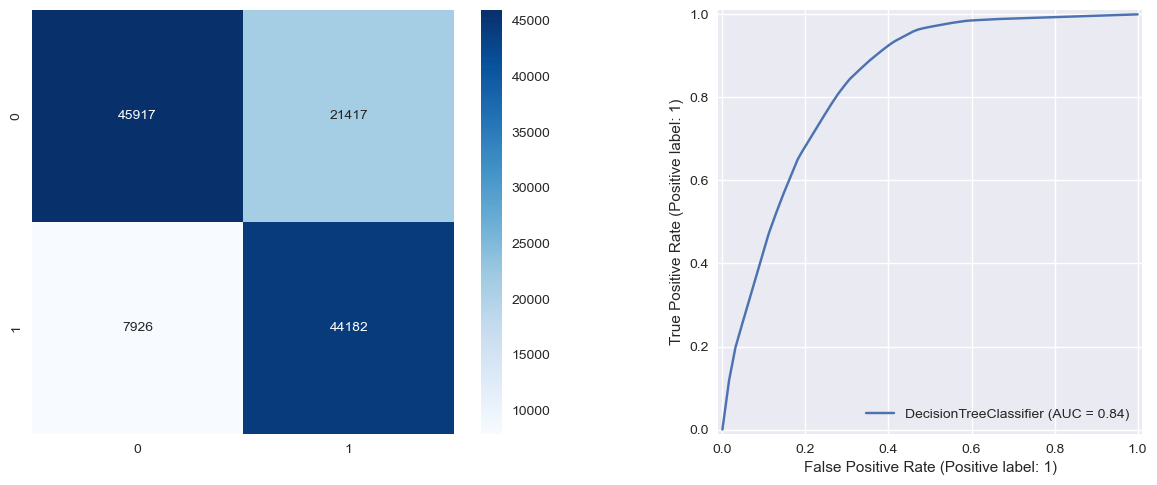

In [33]:
y_pred = cross_val_predict(pipeline_tree, X_train, y_train, cv=skf, n_jobs=-1)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
 
sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])
RocCurveDisplay.from_estimator(pipeline_tree, X_train, y_train, ax=axs[1]) 

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

📈 ROC-кривая и матрица ошибок на тестовой выборке:  

Text(0.5, 1.0, 'Confusion Matrix')

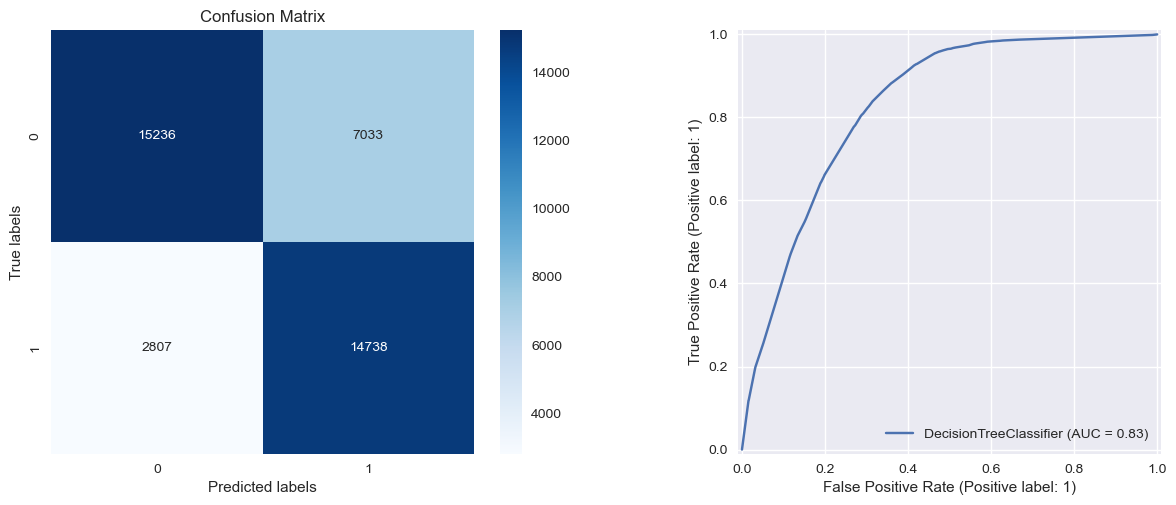

In [34]:
y_pred = pipeline_tree.predict(X_test)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axs[0])
RocCurveDisplay.from_estimator(pipeline_tree, X_test, y_test, ax=axs[1])

axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')
axs[0].set_title('Confusion Matrix')

Общая оценка производительности модели на тестовом наборе:

In [35]:
y_true = y_test
y_pred = pipeline_tree.predict(X_test)

y_pred_proba = pipeline_tree.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_true, y_pred):.5f}")

scores = precision_recall_fscore_support(y_true, y_pred)
scores = pd.DataFrame(scores, index=['Precision', 'Recall', 'F-Score', 'Support'])
scores['Mean'] = scores.mean('columns')

roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC:  {roc_auc:.5f}")

scores

Accuracy: 0.75285
ROC-AUC:  0.82915


,0,1,Mean
Precision,0.844427,0.676956,0.760691
Recall,0.684180,0.840011,0.762096
F-Score,0.755904,0.749720,0.752812
Support,22269.000000,17545.000000,19907.000000


### Оптимизация гиперпараметров с Optuna

#### Установка и импорт

In [36]:

# Установка Optuna (если не установлен)
# !pip install optuna

import optuna
from optuna.samplers import TPESampler
from optuna.study import create_study
import time
import warnings
warnings.filterwarnings('ignore')


optuna.logging.set_verbosity(optuna.logging.WARNING)


print(f" Версия Optuna: {optuna.__version__}")


 Версия Optuna: 4.6.0


#### Подготовка данных для оптимизации

📊 Размер выборок для оптимизации:

Тренировочная (70%):   83609 примеров
Валидационная (30%):   35833 примеров

✅ Баланс классов (train_opt):


,count,pct
smoking,,
0,47134,56.37
1,36475,43.63



✅ Баланс классов (val_opt):


,count,pct
smoking,,
0,20200,56.37
1,15633,43.63


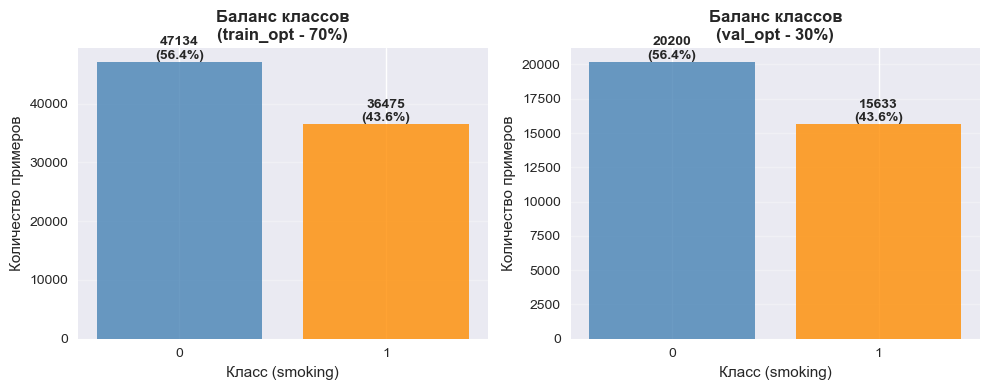

In [ ]:

# Создадим валидационную выборку из train
# Полный train используем для финального обучения

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = next(sss.split(X_train, y_train))

X_train_opt = X_train.iloc[train_idx]
y_train_opt = y_train.iloc[train_idx]
X_val_opt = X_train.iloc[val_idx]
y_val_opt = y_train.iloc[val_idx]

print("📊 Размер выборок для оптимизации:\n")
print(f"Тренировочная (70%):   {X_train_opt.shape[0]} примеров")
print(f"Валидационная (30%):   {X_val_opt.shape[0]} примеров")

# Баланс классов в train_opt
print(f"\n✅ Баланс классов (train_opt):")
cls_train_opt = y_train_opt.value_counts().sort_index()
df_cls_train = pd.DataFrame({
    "count": cls_train_opt, 
    "pct": (cls_train_opt / len(y_train_opt) * 100).round(2)
})
display(df_cls_train)

# Баланс классов в val_opt
print(f"\n✅ Баланс классов (val_opt):")
cls_val_opt = y_val_opt.value_counts().sort_index()
df_cls_val = pd.DataFrame({
    "count": cls_val_opt, 
    "pct": (cls_val_opt / len(y_val_opt) * 100).round(2)
})
display(df_cls_val)

# Визуализация баланса классов в обеих выборках
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# График для train_opt
axs[0].bar(cls_train_opt.index.astype(str), cls_train_opt.values, color=['steelblue', 'darkorange'], alpha=0.8)
axs[0].set_title("Баланс классов\n(train_opt - 70%)", fontsize=12, fontweight='bold')
axs[0].set_xlabel("Класс (smoking)")
axs[0].set_ylabel("Количество примеров")
axs[0].grid(True, alpha=0.3, axis='y')
for i, (idx, val) in enumerate(zip(cls_train_opt.index, cls_train_opt.values)):
    pct = (val / len(y_train_opt) * 100)
    axs[0].text(i, val, f'{val}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

# График для val_opt
axs[1].bar(cls_val_opt.index.astype(str), cls_val_opt.values, color=['steelblue', 'darkorange'], alpha=0.8)
axs[1].set_title("Баланс классов\n(val_opt - 30%)", fontsize=12, fontweight='bold')
axs[1].set_xlabel("Класс (smoking)")
axs[1].set_ylabel("Количество примеров")
axs[1].grid(True, alpha=0.3, axis='y')
for i, (idx, val) in enumerate(zip(cls_val_opt.index, cls_val_opt.values)):
    pct = (val / len(y_val_opt) * 100)
    axs[1].text(i, val, f'{val}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()




#### Optuna оптимизация для LogisticRegression (Objective функция)

In [42]:
# Objective функция для LogisticRegression - это функция, которую Optuna будет минимизировать/максимизировать
def objective_lr(trial):
    """
    Функция для оптимизации LogisticRegression
    trial - объект Optuna, через который мы предлагаем значения гиперпараметров
    """
    
    # Предлагаем значения гиперпараметров
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)  # Обратная регуляризация
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])  # Тип регуляризации
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])  # Решатель
    max_iter = trial.suggest_int('max_iter', 100, 2000, step=100)  # Макс итерации
    
    # Создаём модель с предложенными параметрами
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        max_iter=max_iter,
        random_state=42,
        class_weight='balanced'
    )
    
    # Обучаем на тренировочной выборке
    model.fit(X_train_opt, y_train_opt)
    
    # Оцениваем на валидационной выборке (ROC-AUC)
    y_pred_proba = model.predict_proba(X_val_opt)[:, 1]
    roc_auc = roc_auc_score(y_val_opt, y_pred_proba)
    
    return roc_auc

print("✅ Objective функция для LogisticRegression определена")


✅ Objective функция для LogisticRegression определена


#### Запуск Optuna оптимизации для LogisticRegression

In [43]:

start_time = time.time()

# Создаём study с TPE sampler (Tree-structured Parzen Estimator)
sampler_lr = TPESampler(seed=42)
study_lr = create_study(
    direction='maximize',
    sampler=sampler_lr
)

# Запускаем оптимизацию
study_lr.optimize(objective_lr, n_trials=100, show_progress_bar=True)

optuna_lr_time = time.time() - start_time

print(f"\n✅ Оптимизация завершена!")
print(f"Время выполнения: {optuna_lr_time:.2f} сек\n")

print(f"Лучший найденный ROC-AUC (валидация): {study_lr.best_value:.6f}")
print(f"\n Лучшие гиперпараметры для LogisticRegression:")
for key, value in study_lr.best_params.items():
    print(f"   • {key}: {value}")




  0%|          | 0/100 [00:00<?, ?it/s]


✅ Оптимизация завершена!
Время выполнения: 64739.50 сек

Лучший найденный ROC-AUC (валидация): 0.844240

 Лучшие гиперпараметры для LogisticRegression:
   • C: 99.02654300864043
   • penalty: l1
   • solver: liblinear
   • max_iter: 1300


####  Анализ истории оптимизации - График ROC-AUC по trials

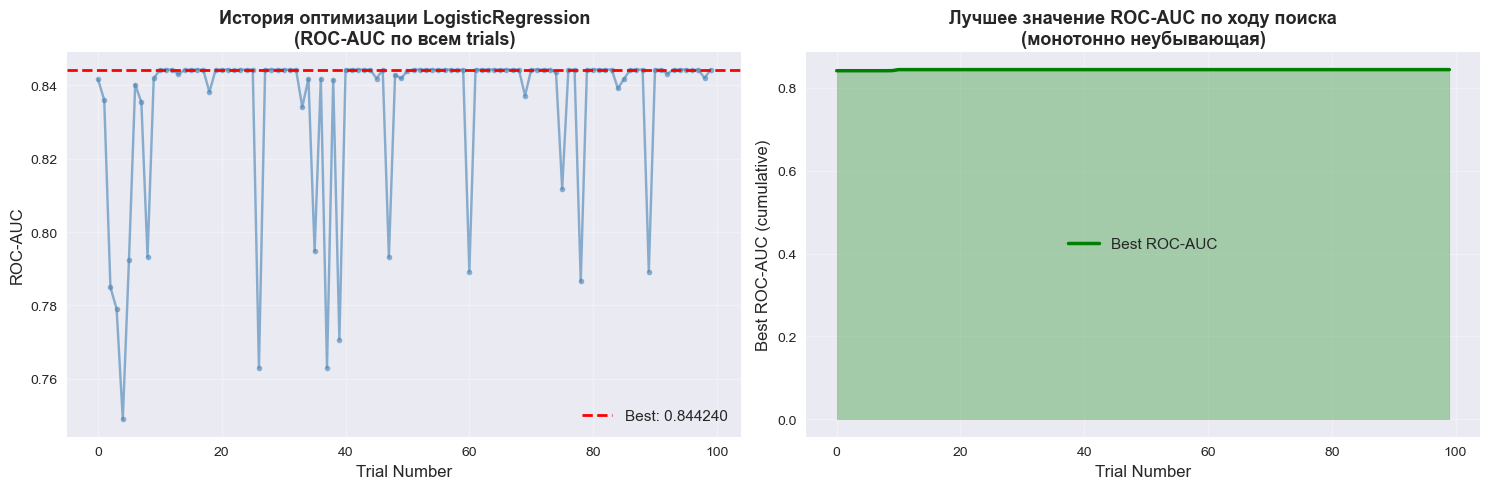

In [44]:

# Подготовка данных для графиков
trials_df = study_lr.trials_dataframe()

# График истории оптимизации
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# График 1: История значений ROC-AUC по trials
axs[0].plot(trials_df['number'], trials_df['value'], 'o-', alpha=0.6, color='steelblue', markersize=4)
axs[0].axhline(y=study_lr.best_value, color='r', linestyle='--', linewidth=2, label=f'Best: {study_lr.best_value:.6f}')
axs[0].set_xlabel('Trial Number', fontsize=12)
axs[0].set_ylabel('ROC-AUC', fontsize=12)
axs[0].set_title('История оптимизации LogisticRegression\n(ROC-AUC по всем trials)', fontsize=13, fontweight='bold')
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# График 2: Прогресс лучшего значения (cumulative best)
best_values = []
for i, trial in enumerate(study_lr.trials):
    if trial.state == optuna.trial.TrialState.COMPLETE and trial.value is not None:
        if i == 0:
            best_values.append(trial.value)
        else:
            best_values.append(max(best_values[-1], trial.value))
    else:
        if i > 0:
            best_values.append(best_values[-1])

axs[1].plot(range(len(best_values)), best_values, 'g-', linewidth=2.5, label='Best ROC-AUC')
axs[1].fill_between(range(len(best_values)), best_values, alpha=0.3, color='green')
axs[1].set_xlabel('Trial Number', fontsize=12)
axs[1].set_ylabel('Best ROC-AUC (cumulative)', fontsize=12)
axs[1].set_title('Лучшее значение ROC-AUC по ходу поиска\n(монотонно неубывающая)', fontsize=13, fontweight='bold')
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()




####  Анализ того, какие гиперпараметры наиболее влияют на качество модели

📊 Анализ важности гиперпараметров (Parameter Importance)



,Параметр,Важность
0,solver,0.961862
1,max_iter,0.037156
2,penalty,0.000871
3,C,0.000111


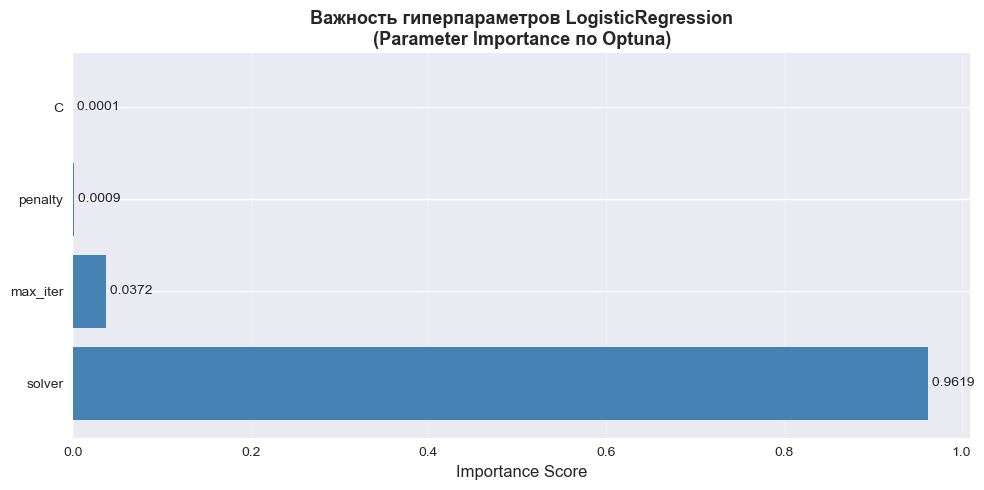


✅ Самый важный параметр: solver


In [45]:

print("📊 Анализ важности гиперпараметров (Parameter Importance)\n")

# Получаем важность каждого параметра
param_importance = optuna.importance.get_param_importances(study_lr)

# Создаём DataFrame
importance_df = pd.DataFrame(
    list(param_importance.items()), 
    columns=['Параметр', 'Важность']
).sort_values('Важность', ascending=False)

display(importance_df)

# График важности
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(importance_df['Параметр'], importance_df['Важность'], color='steelblue')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Важность гиперпараметров LogisticRegression\n(Parameter Importance по Optuna)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Добавляем значения на столбцы
for i, (param, val) in enumerate(zip(importance_df['Параметр'], importance_df['Важность'])):
    ax.text(val, i, f' {val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Самый важный параметр: " + importance_df.iloc[0]['Параметр'])


#### Обучение LogisticRegression с оптимальными параметрами

In [46]:

print("🎓 Обучение финальной LogisticRegression с оптимальными параметрами\n")

# Создаём финальную модель с лучшими параметрами
model_lr_optuna = LogisticRegression(
    **study_lr.best_params,
    random_state=42,
    class_weight='balanced'
)

# Обучаем на ПОЛНОЙ тренировочной выборке
model_lr_optuna.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred_lr_opt = model_lr_optuna.predict(X_test)
y_pred_proba_lr_opt = model_lr_optuna.predict_proba(X_test)[:, 1]

# Метрики
accuracy_lr_opt = accuracy_score(y_test, y_pred_lr_opt)
precision_lr_opt, recall_lr_opt, f1_lr_opt, _ = precision_recall_fscore_support(y_test, y_pred_lr_opt, average='weighted')
roc_auc_lr_opt = roc_auc_score(y_test, y_pred_proba_lr_opt)

print(f"📈 Метрики LogisticRegression (Optuna) на тесте:\n")
print(f"   Accuracy:  {accuracy_lr_opt:.6f}")
print(f"   Precision: {precision_lr_opt:.6f}")
print(f"   Recall:    {recall_lr_opt:.6f}")
print(f"   F1-Score:  {f1_lr_opt:.6f}")
print(f"   ROC-AUC:   {roc_auc_lr_opt:.6f}")

# Детальная таблица метрик
scores_lr_opt = precision_recall_fscore_support(y_test, y_pred_lr_opt)
scores_lr_opt_df = pd.DataFrame(scores_lr_opt, 
                                 index=['Precision', 'Recall', 'F-Score', 'Support'])

print(f"\n📊 Детальные метрики по классам:")
display(scores_lr_opt_df)


🎓 Обучение финальной LogisticRegression с оптимальными параметрами

📈 Метрики LogisticRegression (Optuna) на тесте:

   Accuracy:  0.760034
   Precision: 0.772090
   Recall:    0.760034
   F1-Score:  0.760738
   ROC-AUC:   0.841312

📊 Детальные метрики по классам:


,0,1
Precision,0.835648,0.691420
Recall,0.710764,0.822571
F-Score,0.768163,0.751314
Support,22269.000000,17545.000000


#### Сравнение с baseline LogisticRegression

🔄 Сравнение Baseline vs Optuna Оптимизация


📊 Сравнительная таблица:



,Metric,Baseline,Optuna,Improvement,Improvement (%)
0,Accuracy,0.7597,0.760034,0.000334,0.04
1,Precision,0.6909,0.763534,0.072634,10.51
2,Recall,0.8228,0.766667,-0.056133,-6.82
3,F-Score,0.7511,0.759739,0.008639,1.15
4,ROC-AUC,0.8415,0.841312,-0.000188,-0.02


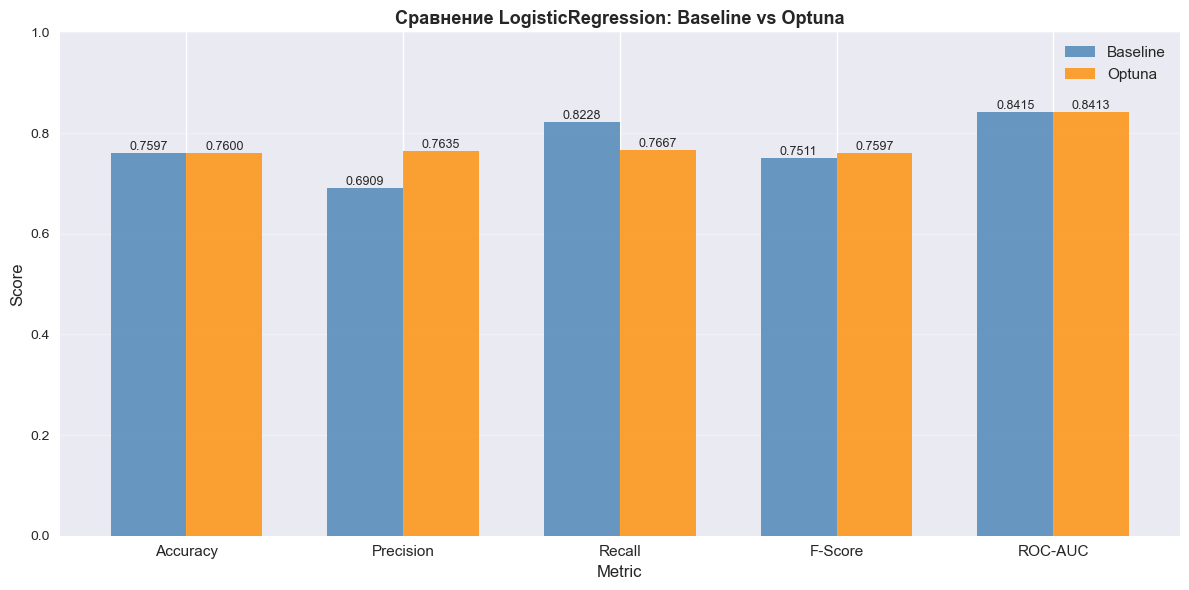

In [48]:

print("🔄 Сравнение Baseline vs Optuna Оптимизация\n")
print("=" * 70)

# Сравним с baseline моделью 
comparison_lr = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F-Score', 'ROC-AUC'],
    'Baseline': [0.7597, 0.6909, 0.8228, 0.7511, 0.8415],  
    'Optuna': [
        accuracy_lr_opt,                          
        scores_lr_opt_df.loc['Precision'].mean(), 
        scores_lr_opt_df.loc['Recall'].mean(),    
        scores_lr_opt_df.loc['F-Score'].mean(),   
        roc_auc_lr_opt                            
    ]
})

comparison_lr['Improvement'] = (comparison_lr['Optuna'] - comparison_lr['Baseline']).round(6)
comparison_lr['Improvement (%)'] = (comparison_lr['Improvement'] / comparison_lr['Baseline'] * 100).round(2)

print("\n📊 Сравнительная таблица:\n")
display(comparison_lr)

# График сравнения
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_lr))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_lr['Baseline'], width, label='Baseline', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, comparison_lr['Optuna'], width, label='Optuna', alpha=0.8, color='darkorange')

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Сравнение LogisticRegression: Baseline vs Optuna', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_lr['Metric'], fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


